# 0.0 IMPORTS

In [2]:
import math
import random
import pickle
import requests
import datetime
import inflection

import numpy   as np
import pandas  as pd
import seaborn as sns
import xgboost as xgb

from scipy                 import stats
from boruta                import BorutaPy
from tabulate              import tabulate
from IPython.core.display  import HTML
from IPython.display       import Image
from matplotlib            import pyplot as plt

from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, MinMaxScaler

## 0.1 Helper Functions

In [3]:
def cross_validation (x_training, kfold, model_name, model, verbose = False): #função criada para aplicar o cross validation. Recebe 5 parametros: x_training (dataframe com as variaveis selecionadas pelo Boruta), kfold:                                                                               numero de repartições.3 formato do nome no dataframe . 4 modelo de Machine Learning desejado!. 5 Verbose para os metodos não lineares
    mae_list = [] #listas criadas para chegamos as valores da media e desvio padrão dos erros
    mape_list = []
    rmse_list = []

    for k in reversed(range(1,kfold+1)):
        
        if verbose:
            print(f'\nkfold Number: {k}')

        #start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7) #subtraindo as ultimas seis semanas do dataset, onde será o inicio da separação do dataset para ser o validation
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7) #subtraindo 0 dias, para ser o limitador da data de validation a data maxima do dataset~

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date] # dataset de treino, restante total das semanas fora as 6 semanas de validation
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)] #dataset validation das ultimas 6 semanas

        #training and validation dataset
        #training 
        xtraining = training.drop(['date', 'sales'], axis=1) #pois não podemos treinar o dataset com as colunas datas e vendas, questão já explicado anteriormente
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        #model
        m = model.fit(xtraining, ytraining)

        #prediction 
        yhat = m.predict(xvalidation)

        m_result = ml_error( model_name , np.expm1(yvalidation), np.expm1(yhat))
        mae_list.append(m_result['MAE']) #adicionando todos os valores de cada erro para calcularmos a media o desvio padrão 
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
    return pd.DataFrame({'Model Name': model_name, #nome do modelo
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str ) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str ) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str ) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0]) #resultado da media e desvião padrão (perfomance real do modelo) dos                                                                                                                                                          erros em forma de dataframe de forma direta

def mean_porcentage_error(y, yhat):
    return np.mean((y-yhat)/y)


def ml_error (model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame ({'Model Name': model_name, #função retorna um dataframe com os erros para avaliarmos os metodos de performance
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index=[0]) #precisamos criar com o index inicial como zero ao criar dataframes com dicionarios, senão da problema!

def cramer_v (x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    
    r , k = cm.shape 
    
    chi2 = stats.chi2_contingency (cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1)) 
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    v = np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
    
    return v

def jupyter_settings():
    %matplotlib inline
    %pylab inline


    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 16]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 15
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/diego/.pyenv/versions/3.10.1/envs/DataScienceEmProducao/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Loading Data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False) #low_memory argumento que avisa para o computador ler o arquivo todo de uma vez, se for true, vai considerar q o pc tem pouca                                                                       memória e ler pedaço por pedaço 
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge 

df_raw = pd.merge (df_sales_raw, df_store_raw, how='left', on='Store') #how = forma que você quer que seja concatenado os datasets (neste caso a coluna Store vai pra esquerda)
                                                                       #on = coluna que existe em comum nos datasets e será referencia na concatenação 

# 1.0 PASSO 01 - DESCRICAO DOS DADOS

In [4]:
df1 = df_raw.copy() #para evitar caso realize mudanças no dataset para não precisar rodar tudo de novo 

In [5]:
df1.columns 

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday','StoreType', 'Assortment','CompetitionDistance','CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x) # inflection = função que aplicar alterações em strings # underscore = função que faz com que as strings fiquem com letras minusculas e separadas por ( _ )
                                               # lambda = função anonima que passa um parametro para executar uma expressão 

cols_new = list(map(snakecase, cols_old)) #map = função para aplicar uma expressão em todos os dados da lista desejada, precisa receber a função e a lista| list = função para retornar uma lista

#rename 
df1.columns = cols_new #renomeando a coluna do dataset com as modificações 

## 1.2 Data Dimensions

In [7]:
print(f'Number of Rows: {df1.shape[0]}') #determinação das estruturas do tamanho do dataset
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [8]:
df1.dtypes #determinação dos tipos das variaveis 

store                            int64
day_of_week                      int64
date                            object
sales                            int64
customers                        int64
                                ...   
competition_open_since_year    float64
promo2                           int64
promo2_since_week              float64
promo2_since_year              float64
promo_interval                  object
Length: 18, dtype: object

In [9]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Check NA

In [10]:
df1.isna().sum() #função para ver os dados faltantes aplicados em conjuntos c a função para somar a quantidade de dados faltantes
                 #três formas de tratar o NA: 
                 #1 - Exclui o NA = Muito mais rapido porem perde muita informação 
                 #2 - Algoritimos de machine learning que façam a substituição baseada no comportamento da coluna
                 #3 - Pensando no negócio (entendo a variavel)

store                               0
day_of_week                         0
date                                0
sales                               0
customers                           0
                                ...  
competition_open_since_year    323348
promo2                              0
promo2_since_week              508031
promo2_since_year              508031
promo_interval                 508031
Length: 18, dtype: int64

## 1.5 Fillout NA

In [11]:
df1['competition_distance'].max()

75860.0

In [12]:
#competition_distance 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x) #apply é uma função que aplica determinada ação para todos os parametros da aréa selecionada
                                                                                                          # math.insan (retorna true ou false) para valores NA
# jogamos um valor acima da maior distancia pois, não temos uma loja competitiva ou está muito longe 

#competition_open_since_month 
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1) #axis= 1 quando usamos um lambda em diferentes                                                                                                                                                                               colunas, precisamos especificar que a ação é                                                                                                                                                                               realizada no decorrer das linhas
#Consideramos que o mes da compra é o mesmo mes para os resultados NA nesta coluna, caso contrario, retorna o mes que já é existente


#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
#Consideramos que o ano da compra é o mesmo ano para os resultados NA nesta coluna, caso contrario, retorna o ano que já é existente

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
#Consideramos que a semana da compra é o mesmo semana para os resultados NA nesta coluna, caso contrario, retorna a semana que já é existente

#promo2_since_year 
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
#Consideramos que o ano da compra é o mesmo ano para os resultados NA nesta coluna, caso contrario, retorna o ano que já é existente

#promo_interval 
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7:'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
# dicionario criado para comparar com a coluna date, para retornar o mes, relatado na data da compra. 

df1['promo_interval'].fillna(0, inplace = True) #inplace True= executa ação e mantem. se False: faz a ação e depois retorna pro estado nroam l
#transformou tudo que é NA em zero 

df1['month_map'] = df1['date'].dt.month.map(month_map) #.map = função para realizar a mudança de variaveis dentro de uma serie, usando o dicionario, troca a chave pelo value
#coluna que retornar os meses descritos no dicionario baseado na data da compra

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis =1)
#coluna criada para nos retornar com 1 se a data de compra foi realizada dentro do periodo de promoção e 0 para a que não foi comprada no periodo de promoção. 

In [13]:
df1.isna().sum()

store                0
day_of_week          0
date                 0
sales                0
customers            0
                    ..
promo2_since_week    0
promo2_since_year    0
promo_interval       0
month_map            0
is_promo             0
Length: 20, dtype: int64

## 1.6 Change types

In [14]:
df1.dtypes #conferindo novamente nossos dados 

store                         int64
day_of_week                   int64
date                 datetime64[ns]
sales                         int64
customers                     int64
                          ...      
promo2_since_week           float64
promo2_since_year           float64
promo_interval               object
month_map                    object
is_promo                      int64
Length: 20, dtype: object

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int) #Função que determina a coluna como inteira
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical 

In [16]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64']) #função para selecionar as colunas pelo tipe delas #include= colunas que desejamos
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]']) #exclude = colunas que não deejamos

In [17]:
num_attributes.sample(2) #função que seleciona linhas aleatórias

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
679762,398,3,4317,505,1,0,0,1540.0,10,2013,1,1,2012,1
38980,1071,6,4459,510,1,0,0,820.0,3,2012,1,35,2012,1


In [18]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
322669,0,c,c,0,Sept
200082,0,a,a,"Jan,Apr,Jul,Oct",Feb


### 1.7.1 Numerical Attributes

In [19]:
#APROFUNDAR MAIS DEPOIS NAS ANALISES DE SKEWNESS E KURTOSIS

# Central Tendency - Mean, median
ct1 = pd.DataFrame (num_attributes.apply(np.mean)).T #apply função para aplicar em todas as colunas uma operação, sem o apply traria a media da coluna inteira
ct2 = pd.DataFrame (num_attributes.apply(np.median)).T


# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame (num_attributes.apply(np.std)).T
d2 = pd.DataFrame (num_attributes.apply(min)).T
d3 = pd.DataFrame (num_attributes.apply(max)).T
d4 = pd.DataFrame (num_attributes.apply(lambda x: x.max() -  x.min())).T
d5 = pd.DataFrame (num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame (num_attributes.apply(lambda x: x.kurtosis())).T
                   
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range', 'mean','median','std','skew','kurtosis']

In [20]:
m #APROFUNDAR MAIS NO APRENDIZADO DE ANALISE DESCRITIVA DAS METRICAS ESTATISTICAS DOS DADOS

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/home/diego/.pyenv/versions/3.10.1/envs/DataScienceEmProducao/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

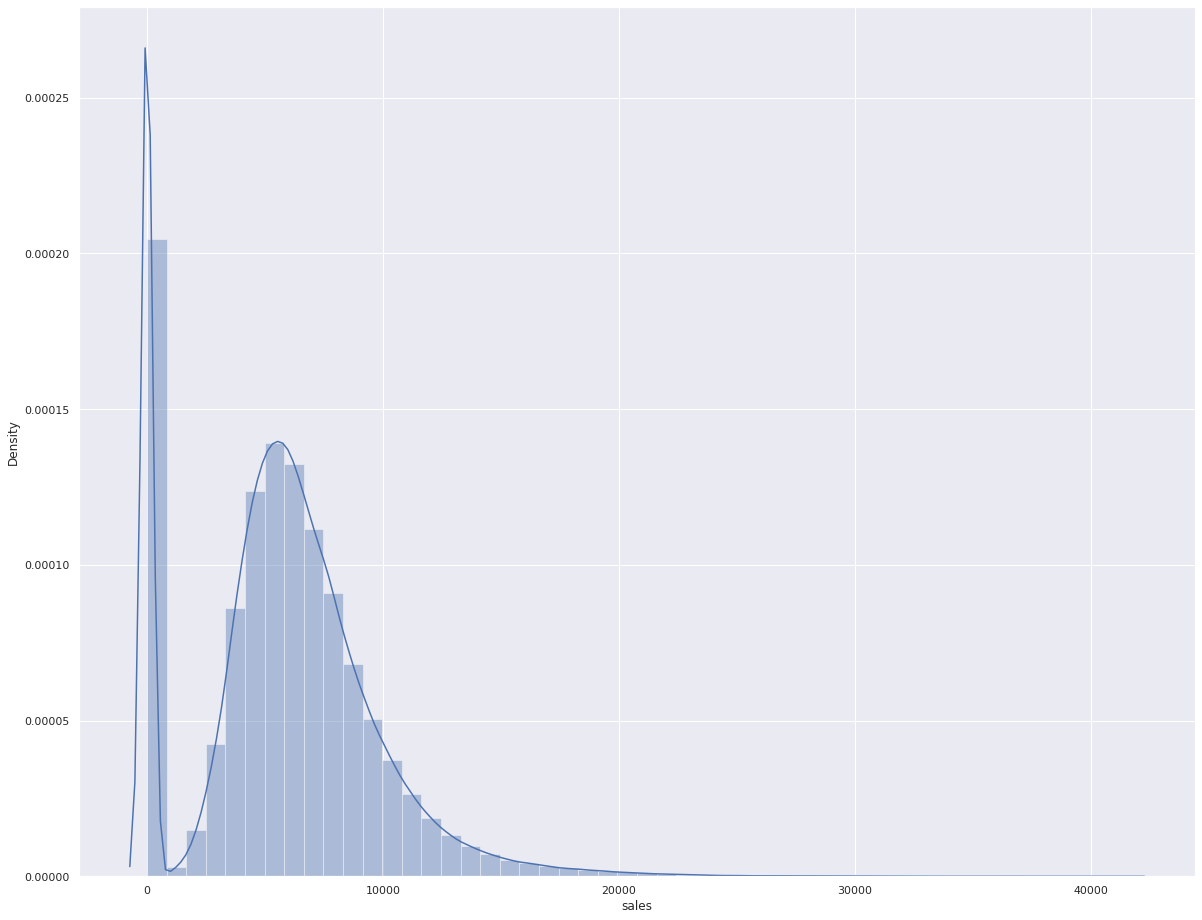

In [21]:
plt.figure(figsize=(20, 16)) #tamanho dos graficos plotados
sns.distplot (df1['sales']) #função para plotar grafico com a distribuição dos preços 

#APROFUNDAR MAIS NAS ANALISES DA DISTRIBUIÇÃO DE VENDAS

### 1.7.2 Categorical Attributes

In [22]:
cat_attributes.apply(lambda x: x.unique().shape[0]) # para ver a quantidade de variaveis diferentes 

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

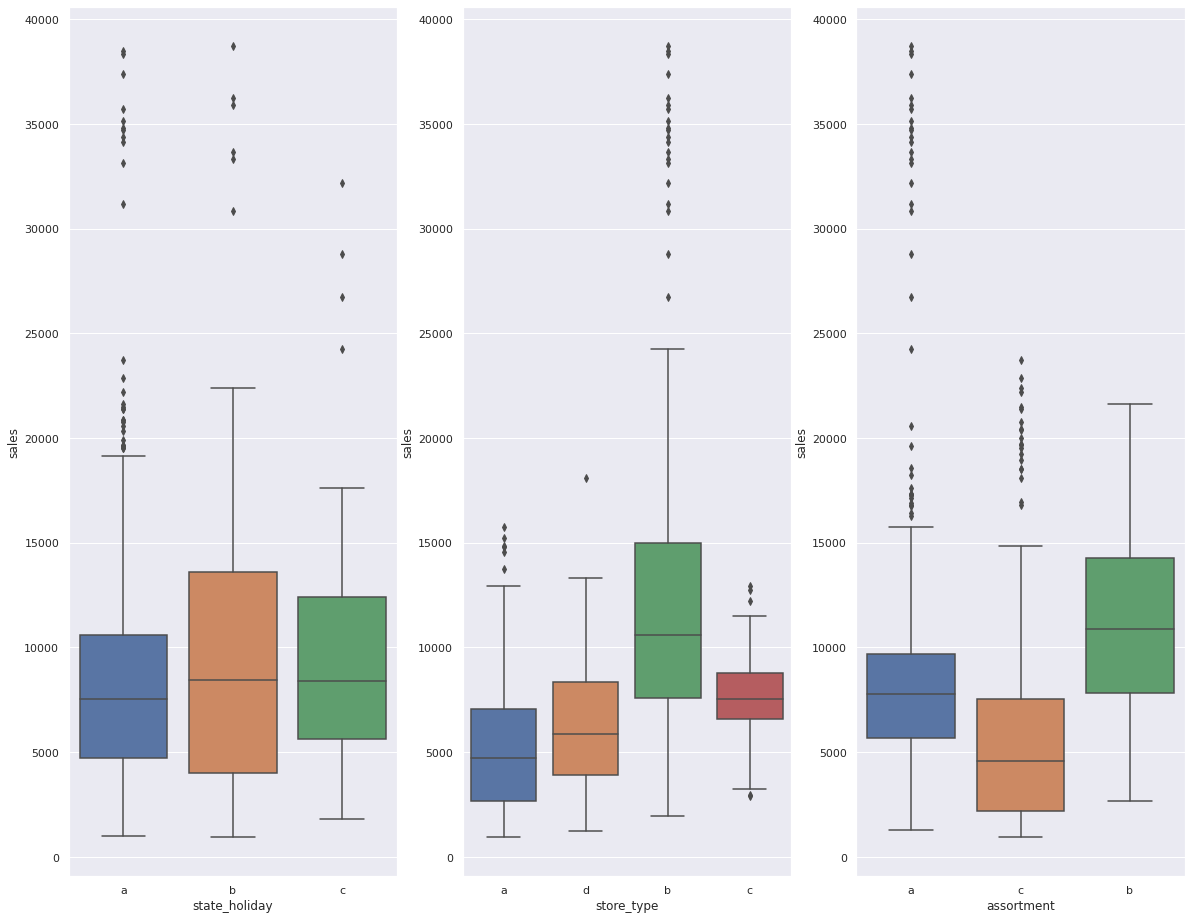

In [23]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(20, 16))

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

#linha do meio é o Q50 ou mediana
#linha de baixo é a Q25, o intervalo é o volume de vendas do Q25 até Q50
#linha de cima é o Q75, o intervalo é o volume de vendas do Q50 até Q75
#os valores fora desse intervalo são considerados outliers 
#linha de baixo é o Q1-1.5* (Q3-Q1)
#linha de cima é o Q3+1.5 *(Q3-Q1)

#No feriado do estado , o feriado B tem uma mediana maior que a do A e parecido com o C, só que tem um equilibrio entre as diferenças de quartil, no c temos diferença no intervalo

#APROFUNDAR MAIS NO COMPORTAMENTO DE VARIAVEIS CATEGORICAS

# 2.0 PASSO 02 - FEATURE ENGINEERING

In [24]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

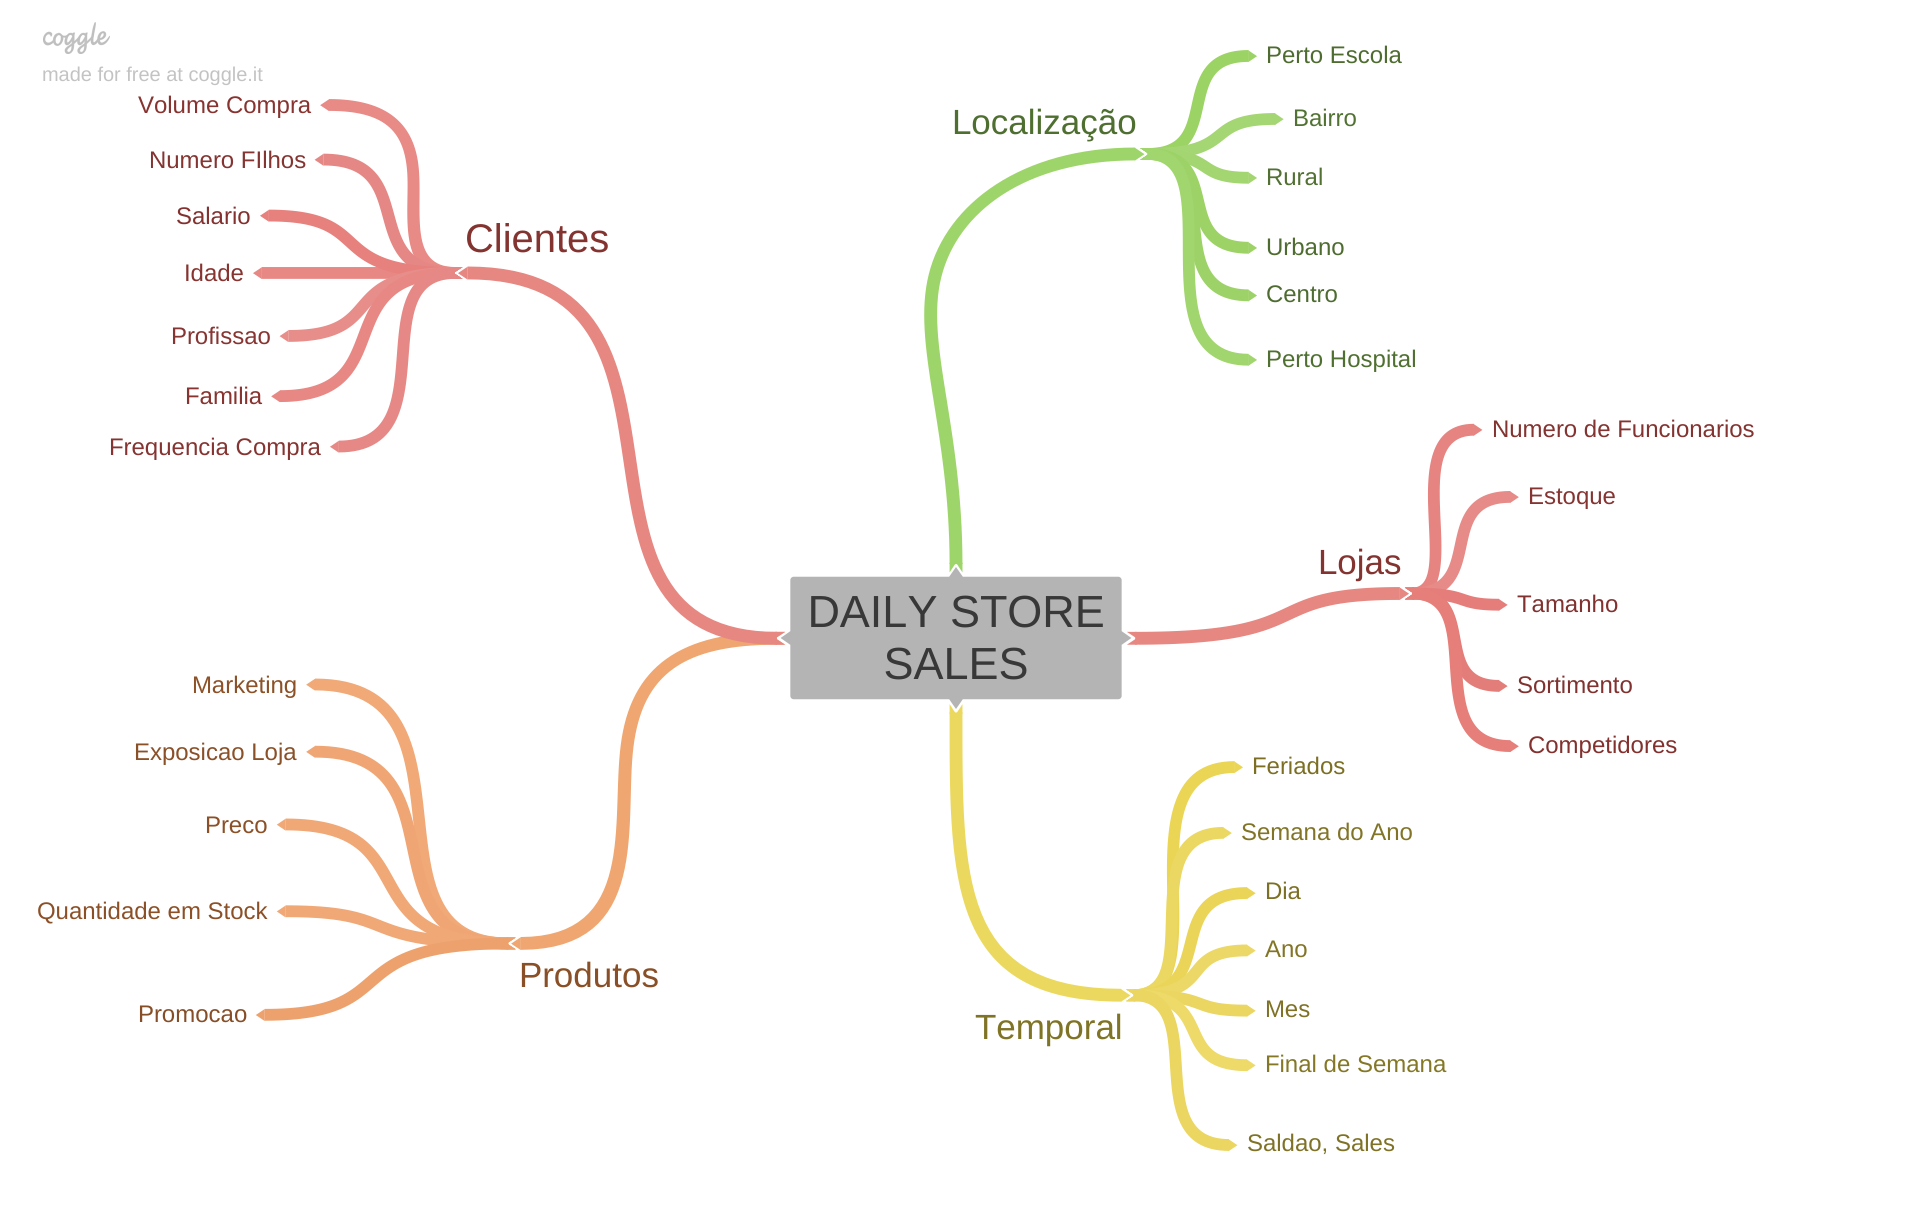

In [25]:
Image('img/MindMapHypothesis.png')

## 2.2 Criação das Hipóteses

### 2.2.1 Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3**. Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Hipoteses Produtos

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.2.4 Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering

In [26]:
#year
df2['year'] = df2['date'].dt.year #função para extrair somente o ano da data

#month
df2['month'] = df2['date'].dt.month #função para extrair somente o mês da data

#day
df2['day'] = df2['date'].dt.day #função para extrair somente o dia da data

#week of year
df2['week_of_week'] = df2['date'].dt.weekofyear #função que retorna o número da semana da data

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W') #função que retorna uma string do objeto da data

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 ) # função para pegar dados de uma data em diferentes                                                                                                                                                                           colunas 
df2['competition_time_month'] = ((df2['date']-df2['competition_since'] )/30).apply( lambda x: x.days).astype(int) #função que extrai os dias da diferença entre duas datas

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str) #transformação da data em string para realizar o join entre elas, separadas por um traço

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x +'-1', '%Y-%W-%w')-datetime.timedelta(days=7)) #formatar a data para saber o inicio da promoçao, pega a semana do ano e retorna pra dia e mes

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days ).astype(int) #quantidade de semanas que a promoção ficou ativa

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended') # substituição das letras da coluna assortment pela palavra que representa

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday'if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' ) # substituição das letras da coluna state holiday pela palavra que representa

#APROFUNDAR MAIS NA MANIPULAÇÃO DE DATAS

/tmp/ipykernel_6435/4240905256.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_week'] = df2['date'].dt.weekofyear #função que retorna o número da semana da data


In [27]:
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_week,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# 3.0 PASSO 03 - FILTRAGEM DE VARIÁVEIS 

In [28]:
df3 = df2.copy()

In [29]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_week,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das Linhas

In [30]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)] # vendas igual a zero não nos ajuda em anda pois queremos saber o acumulo de vendas

## 3.2 Selecao das Colunas

In [31]:
cols_drop = ['customers', 'open', 'promo_interval','month_map']  # Não terei a previsão de pessoas daqui 6 semanas 
                                                                 # Não interessa mais a informação 'open' pois já filtramos as vezes que está aberta
                                                                 # colunas auxiliares 
df3 = df3.drop (cols_drop, axis = 1)

In [32]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_week', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 PASSO 04 - ANALISE EXPLORATORIA DOS DADOS (EDA)

In [33]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.1 Response Variable

/home/diego/.pyenv/versions/3.10.1/envs/DataScienceEmProducao/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

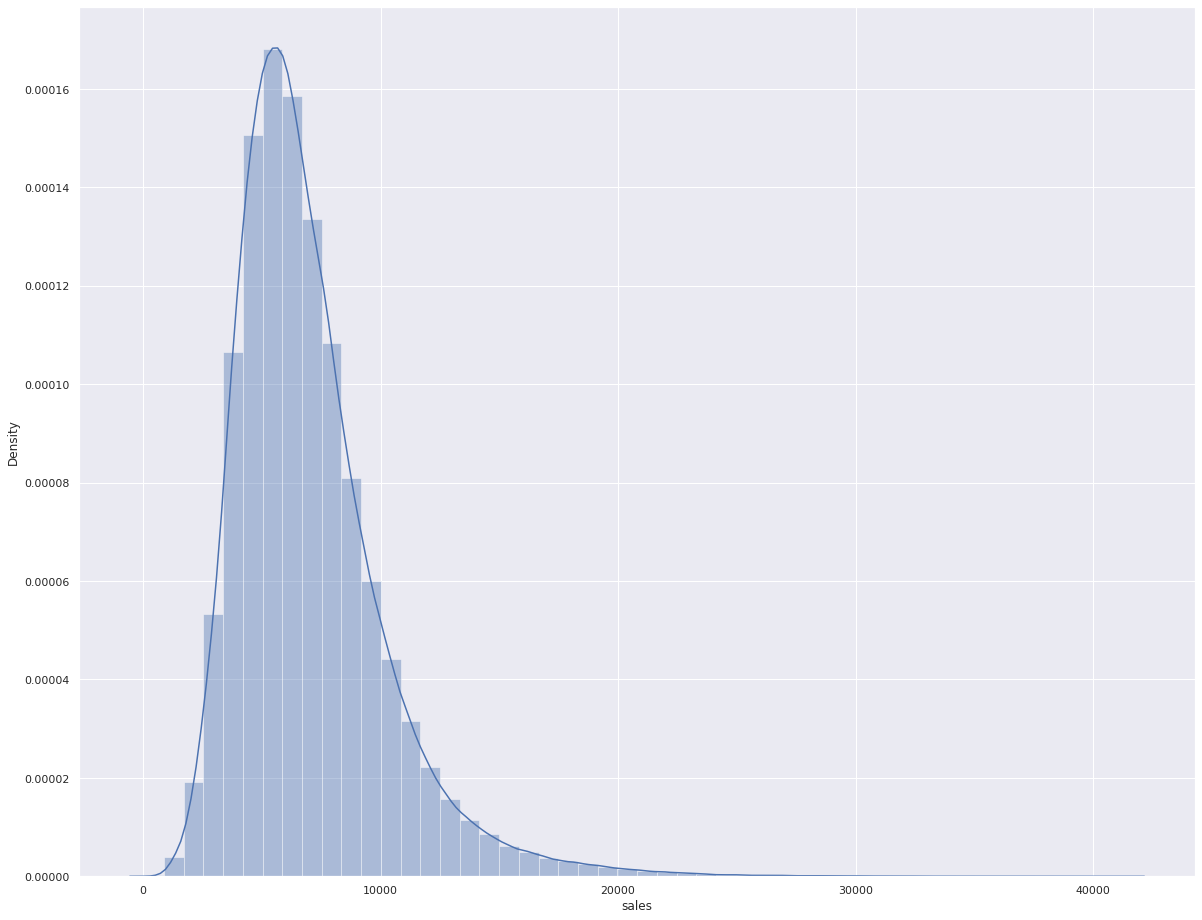

In [34]:
sns.distplot(df4['sales']) #distribuição das vendas #sales = variavel resposta
                           #Formato de sino, tem kurtosis, skew mais para esquerda = positiva, mas não ta centrada, próxima da normal 
                           #Condição esperadas: dados independentes e normalmente distruibuidos, que eles sigam uma distribuição normal, quanto mais normal for a variavel resposta, melhor vai ser                                                     perfomado, existem muitas tecnicas pra isso, como a log, boxpot, etc, depende do conhecimento do negócio 
                           #kde = False, tira a linha e mantem só o histrograma 

### 4.1.2 Numerical Variable

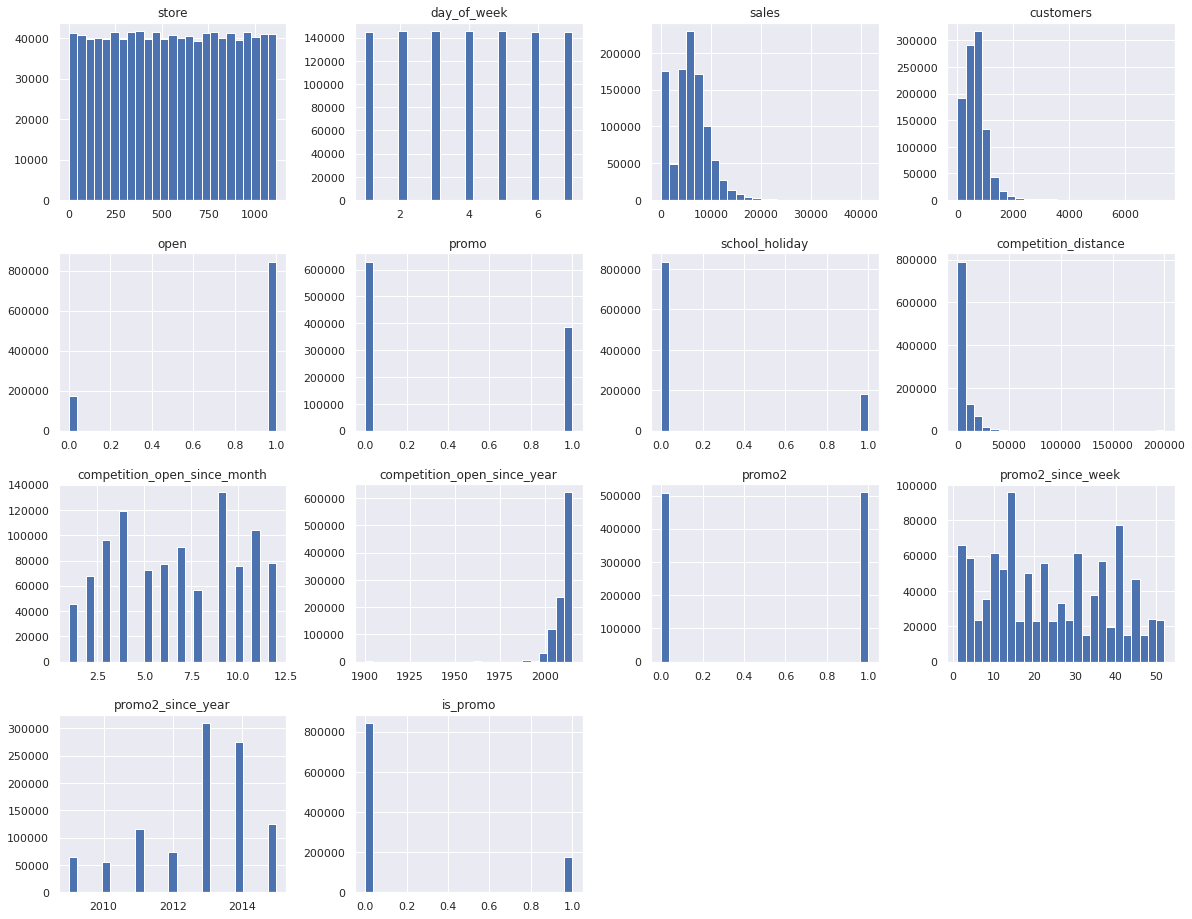

In [35]:
num_attributes.hist( bins = 25); # ' ; ' retira as escritas
                                 # bins cada retangulo pra demonstrar o conjunto de dados

In [36]:
# competition_distance = As vendas são muito maiores quando não tem competidores por perto, e quando tem, aumentam se a distancia aumentar. 

#competition_open_since_month = Não existe um padrão para determinar o que acontece com a vendas quando os competidores abrem suas lojas em um mes ou outro.

#competition_open_since_year = As vendas aumentaram muito com o passar dos anos com a abertura de competidores

# customers = As vendas parecem diminuir com o aumento de pessoas

# day_of_week = As vendas poucam mudam de acordo com o dia da semana

# is_promo = As vendas diminuem quando tem promoção 

# open = Obviamente as vendas são maiores quando estão abertas

# promo = comportamento igual ao da coluna is_promo

# promo2 = Não existe muita diferença com promo ou não 

# primo2_since_week = não existe um padrão de vendas para a quantidade de semanas em promo2

# promo2_since_year = Em 2013 temos um pico muito grande de vendas, dps houve decaimento

# sales = As vendas se concentram mais ou menos em 500 mil

# school_holiday = as vendas são maiores quando não tem feriado escolar 

# store = Não a uma variancia de comportamento 

### 4.1.3 Categorical Variable 

In [37]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [38]:
df4['state_holiday'].drop_duplicates() # ver as variaveis dentro do feriado

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [39]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

/home/diego/.pyenv/versions/3.10.1/envs/DataScienceEmProducao/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/diego/.pyenv/versions/3.10.1/envs/DataScienceEmProducao/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/diego/.pyenv/versions/3.10.1/envs/DataScienceEmProducao/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and pa

<AxesSubplot:xlabel='sales', ylabel='Density'>

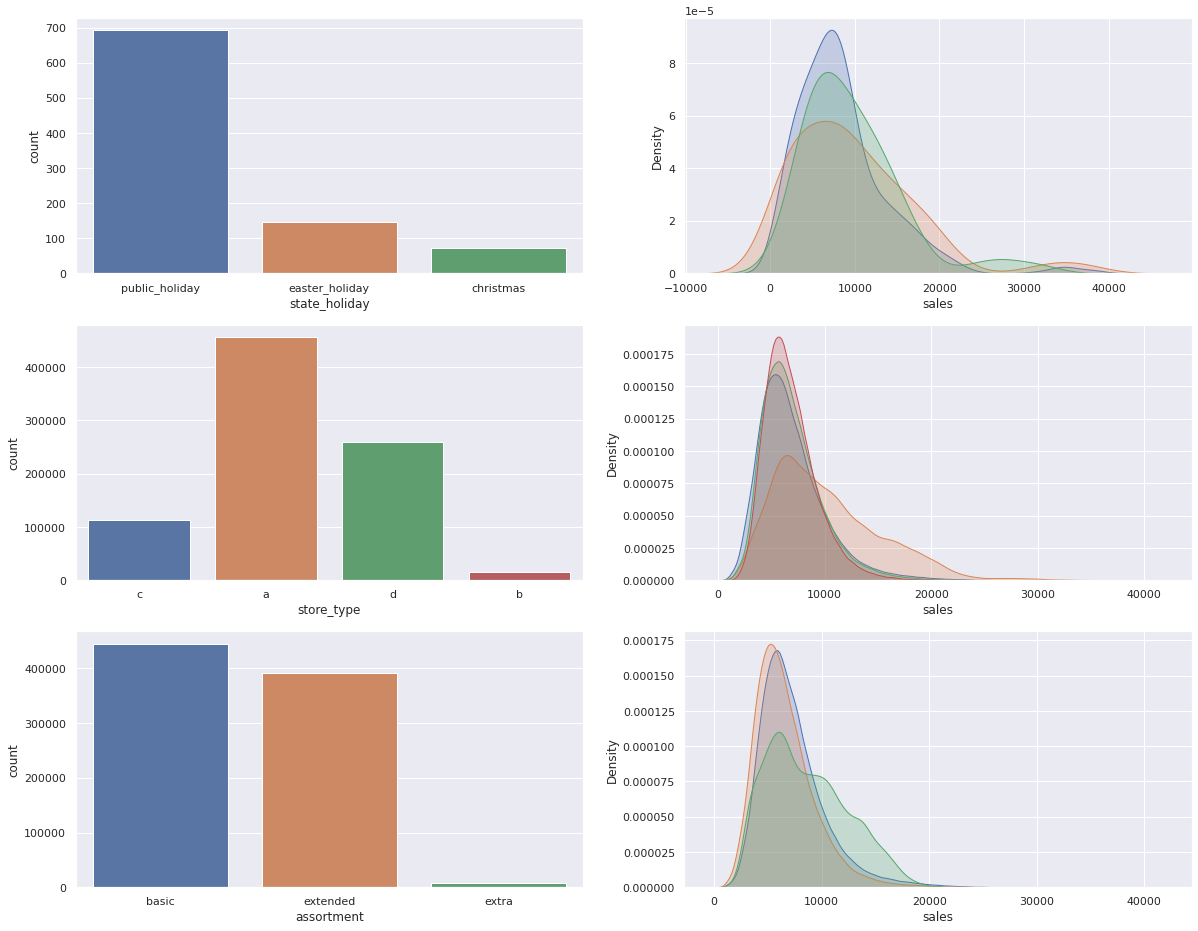

In [40]:
#APROFUNDAR NAS ANALISES APROFUNDADAS DO COMPORTAMENTO DAS VARIAVEIS CATEGORICAS

#state holiday 
plt.subplot(3,2,1) #ajuste de gride
a = df4[df4['state_holiday'] != 'regular_day'] # para vermos a distribuição dos feriados
sns.countplot(a['state_holiday'])              # vemos de forma expressiva apenas os dias regulares, pois temos muito mais dias regulares no ano que feriados (por isso foi selecionado diferente de regular day)
                                               # função da biblioteca que plota um grafico com a contagem de cada variavel 
                                               # label = nome da coluna , shade= deixar sombreado
plt.subplot(3,2,2) #ajuste de gride
sns.kdeplot (df4[df4['state_holiday']  == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot (df4[df4['state_holiday']  == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot (df4[df4['state_holiday']  == 'christmas']['sales'], label='christmas', shade=True)

#store_type
plt.subplot(3,2,3) #ajuste de gride
sns.countplot(df4['store_type'])    

plt.subplot(3,2,4) #ajuste de gride
sns.kdeplot (df4[df4['store_type']  == 'a']['sales'], label='a', shade=True)
sns.kdeplot (df4[df4['store_type']  == 'b']['sales'], label='b', shade=True)
sns.kdeplot (df4[df4['store_type']  == 'c']['sales'], label='c', shade=True)
sns.kdeplot (df4[df4['store_type']  == 'd']['sales'], label='d', shade=True)

#assortment 
plt.subplot(3,2,5) #ajuste de gride
sns.countplot(df4['assortment'])    

plt.subplot(3,2,6) #ajuste de gride
sns.kdeplot (df4[df4['assortment']  == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot (df4[df4['assortment']  == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot (df4[df4['assortment']  == 'extra']['sales'], label='extra', shade=True)

## 4.2 Analise Bivariada

In [41]:
#APROFUNDAR NAS ANALISES EXPLORATORIAS 

In [42]:
#realizamos os testes de hipoteses por 3 motivos.
#1. Ganhar experiência de Negócio
#2. Para validar as hipoteses
#3. Para gerar o promeiro insights se as variaveis tem relevancia pro modelo ou não .

### H1. Lojas com maior sortimentos deveriam vender mais

**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

<AxesSubplot:xlabel='year_week'>

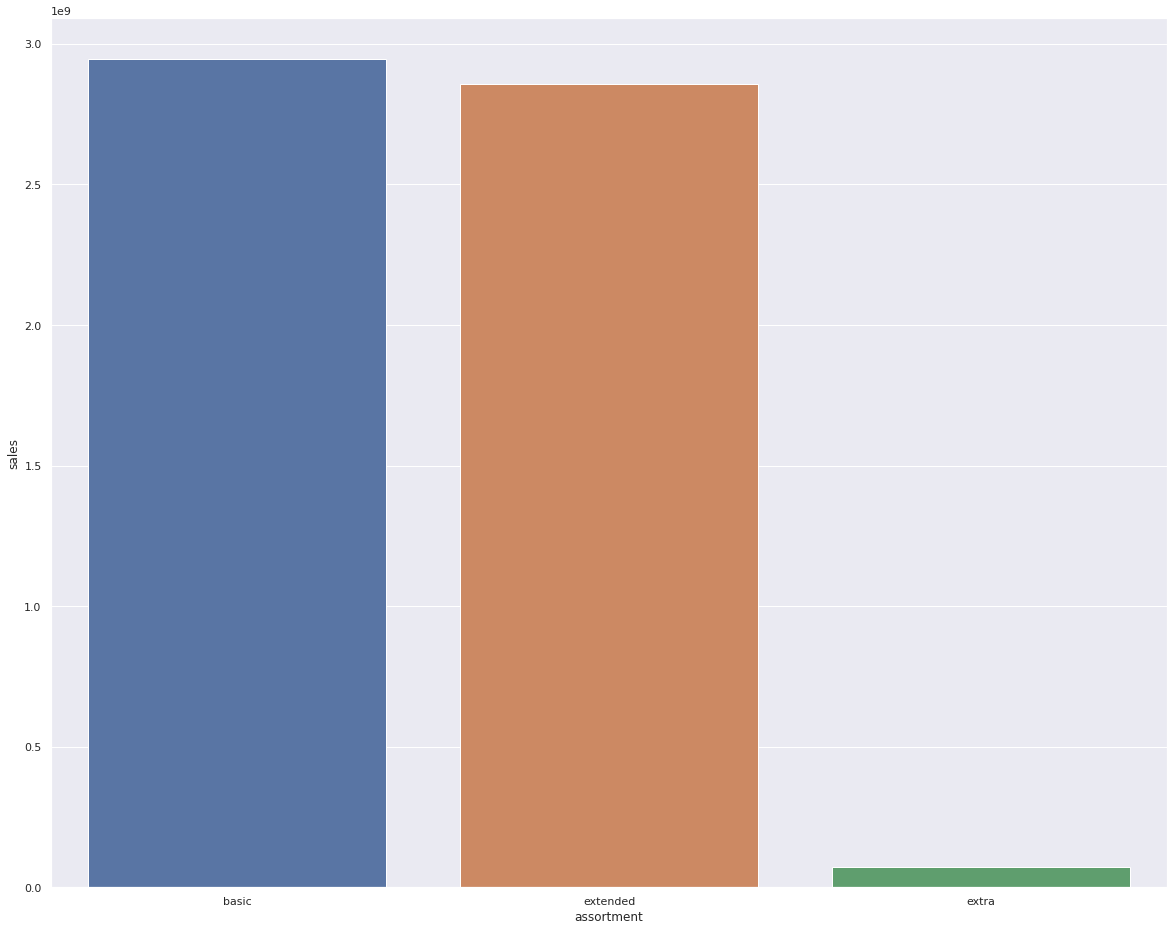

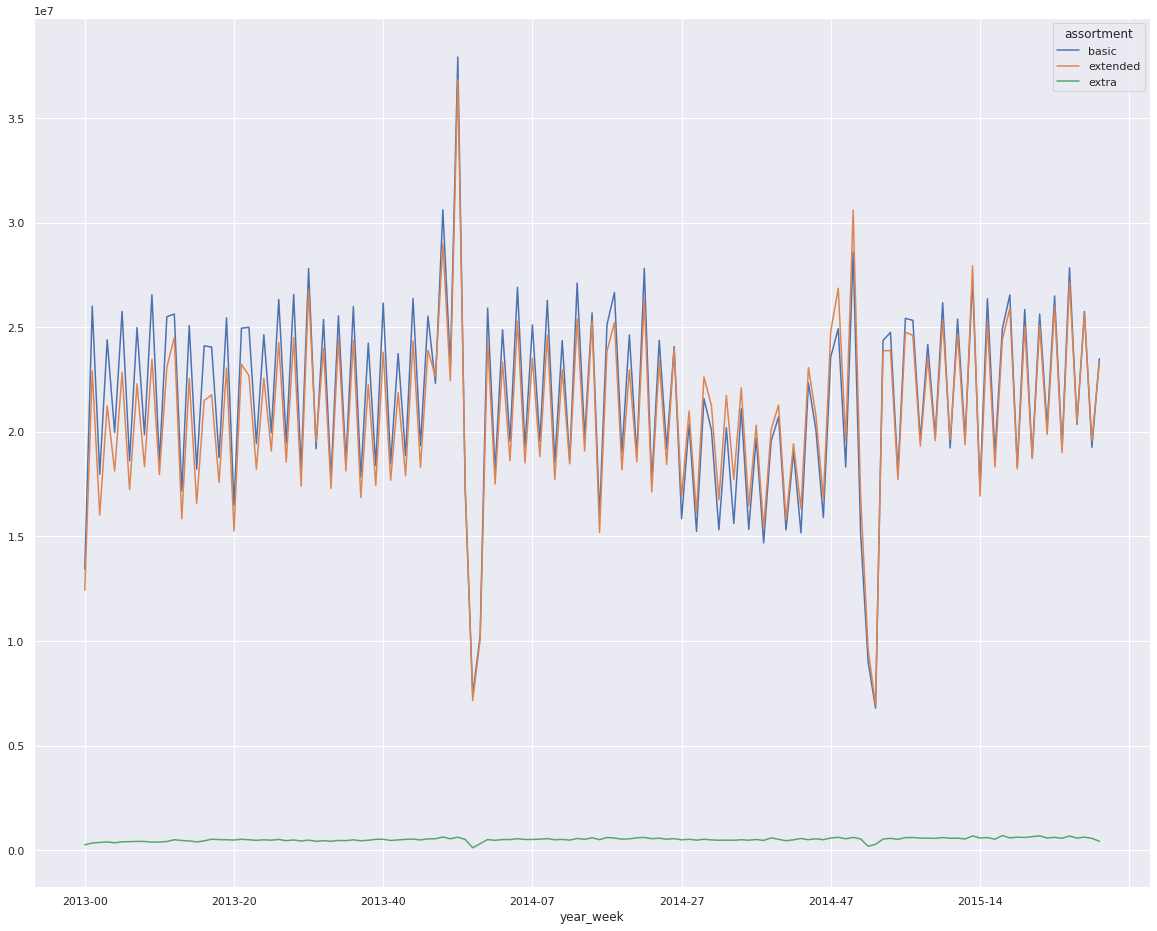

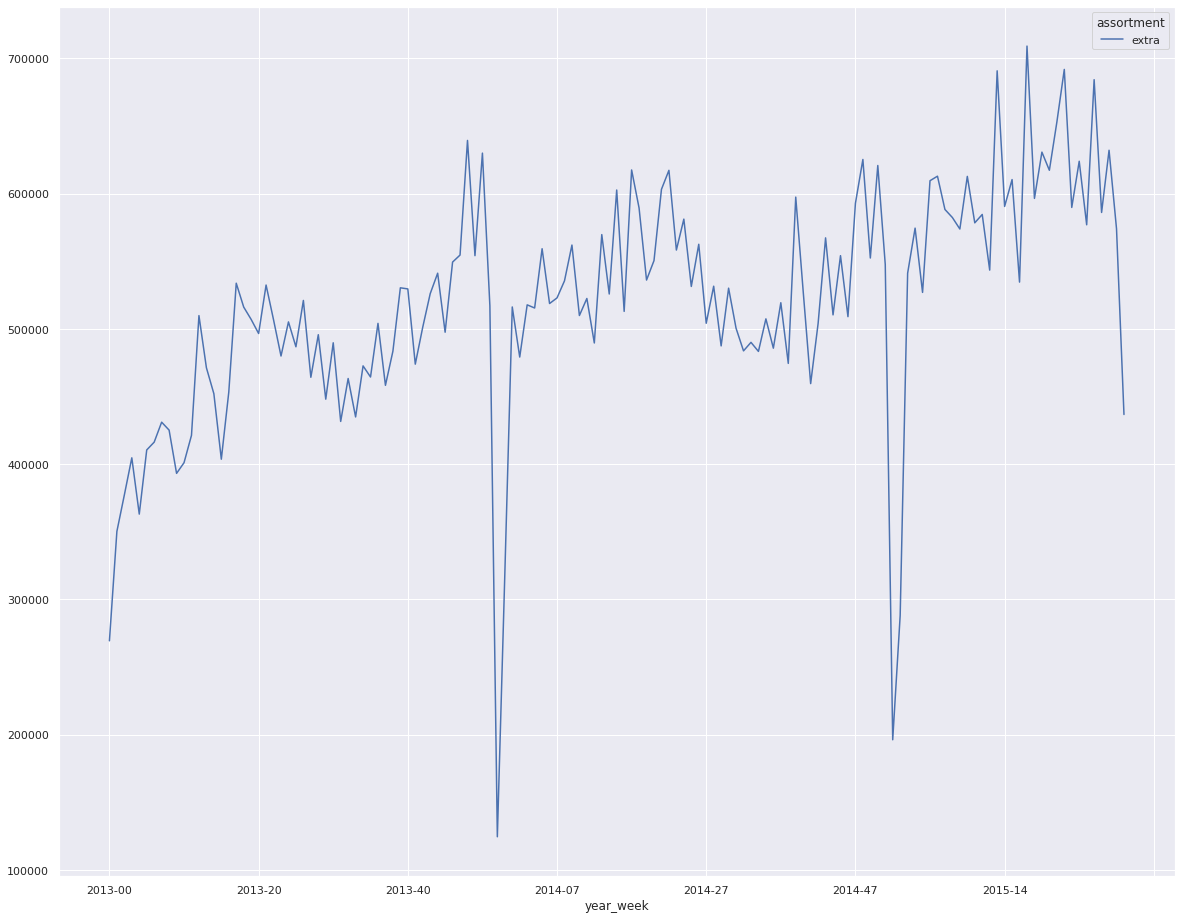

In [43]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index() #segregamos as vendas por tipo de assortment, observamos que a hipotese não era verdeira, pois as vendas com                                                                                        assortment extra são muito menores
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby (['year_week', 'assortment']).sum().reset_index() #devido as vendas serem muito baixas para o tipo extra, consideramos que talvez isso não                                                                                                             tenha sempre sido assim, que pode ter tido vendas maiores anteriormente
aux2.pivot(index = 'year_week', columns ='assortment', values = 'sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra'] # ao observamos que com o passar das semanas no ano, as vendas ainda são baixas, obsevamos também comportamentos que nao dava pra ver no segundo grafico 
aux3.pivot(index = 'year_week', columns ='assortment', values = 'sales').plot()

#conclusao, vende menos, hipotese errada. Lojas com maior sortemento vendem menos
#variavel importante pois, quando formos treinar nosso algoritimo, trabalhara de forma parecida com os outros dois assertments e o extra com valores menores e maiores variações

### H2. Lojas com competidores mais próximos deveriam vender menos

**FALSA** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

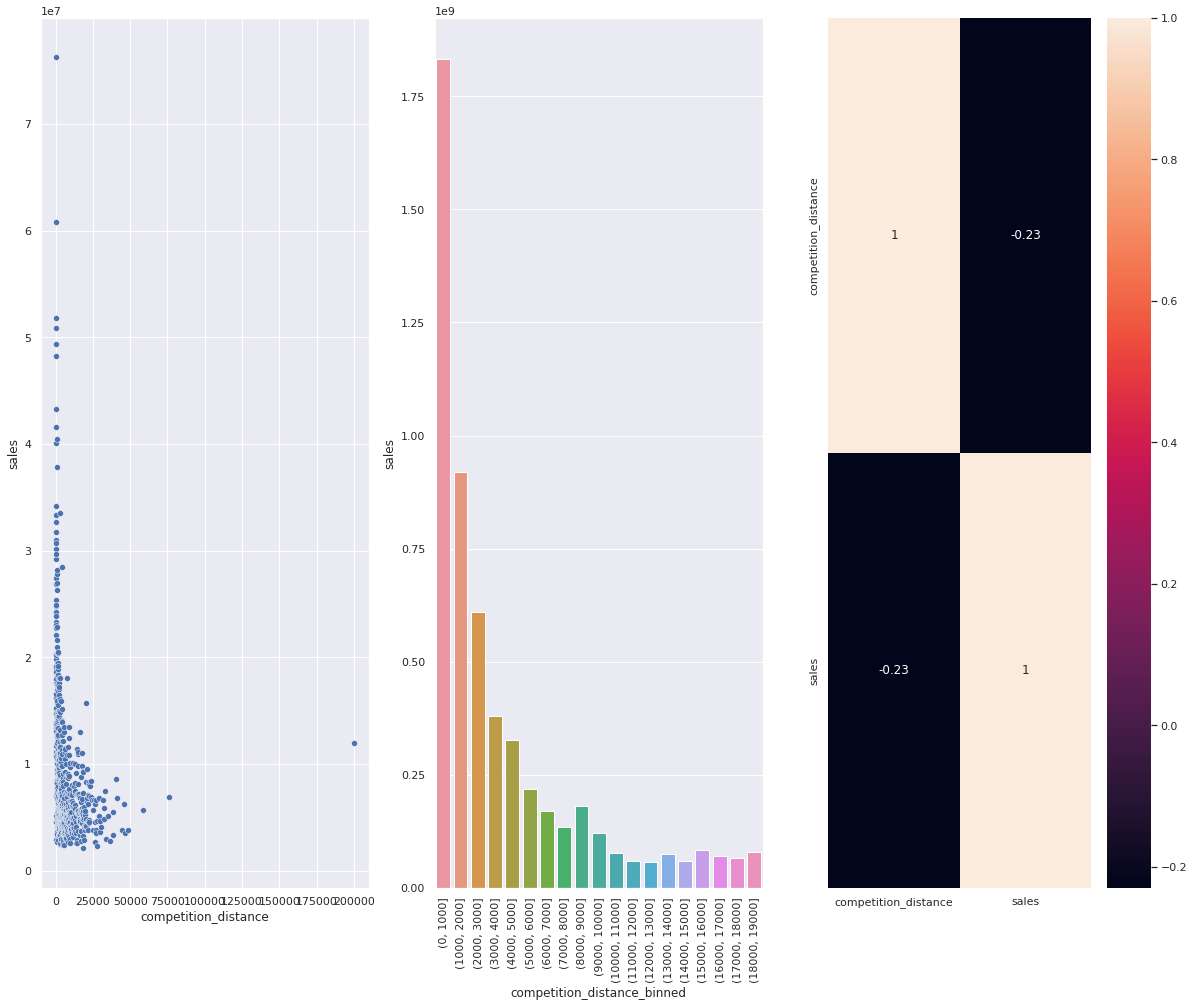

In [44]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 ); #outra forma de ver o grafico quando tiver ruim de ver

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) ) #aumentando 
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'],bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 ); #rotacionar a legenda pra ver melhor

plt.subplot(1,3,3)
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True ); #mais proxima de 0, mais fraca correlação, mais próximo de 1, mais forte. Indicando que quanto mais proximo do concorrente, maior a venda!

# As vendas são maiores com a distancia menor. Insgths chocante, provavelmente pq isso gera um centro economico, empresas fornecendo o mesmo produto, tras mais clientes. 

### H3. Lojas com competidores à mais tempo deveriam vendem mais.

**FALSE** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

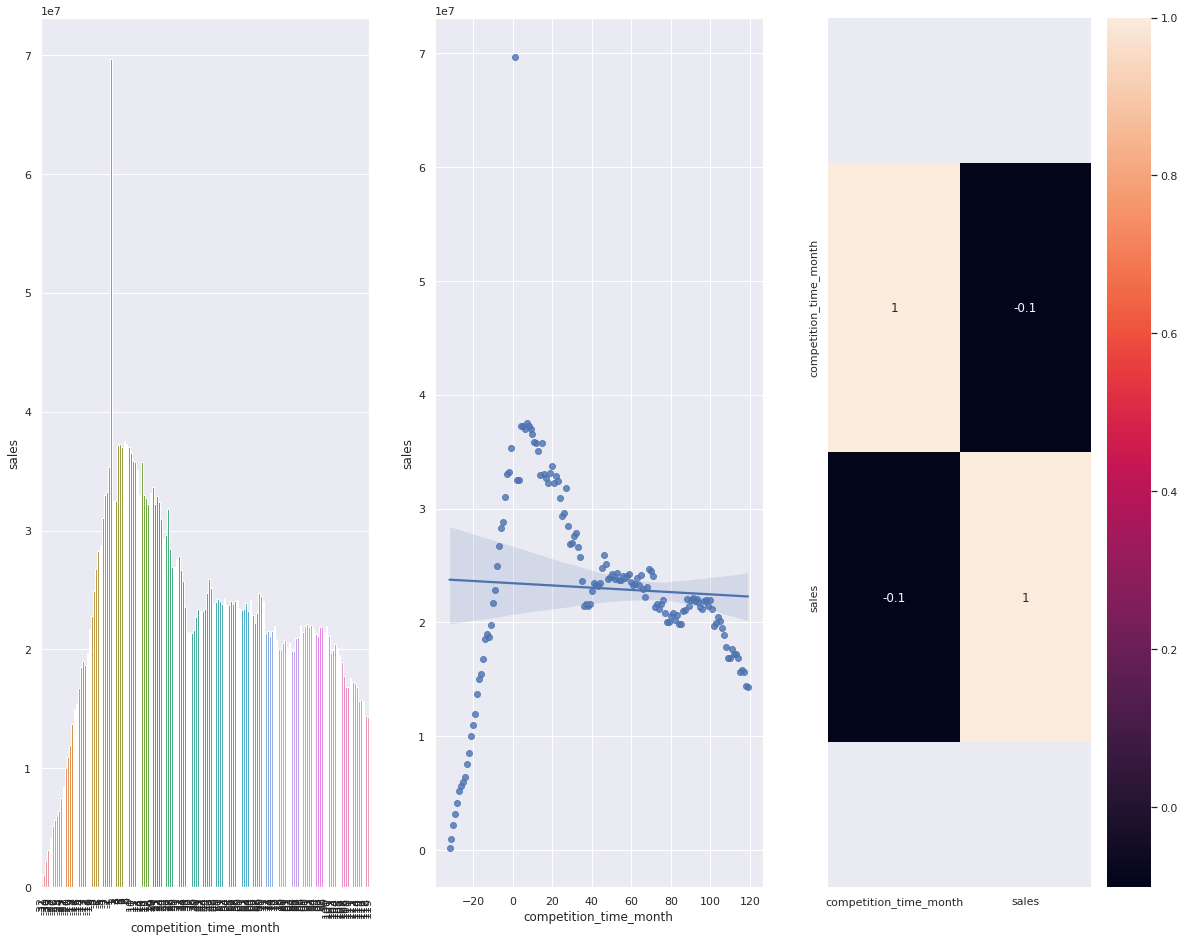

In [45]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index() #queremos ver as vendas por tempo de competição (mes)
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )] #ruim de visualizar, então filtramos até os 120 primeiros dias e que começaram ao mesmo tempo
sns.barplot( x='competition_time_month', y='sales', data=aux2);
plt.xticks( rotation=90 ); #girar a legenda

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 ); # para sabermos as tendencias das vendas 

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True ); #Para sabermos a correlação da variavel 
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

#correlação não tão proxima de zero, hipotese será utilizada

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

**FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo
de promocao

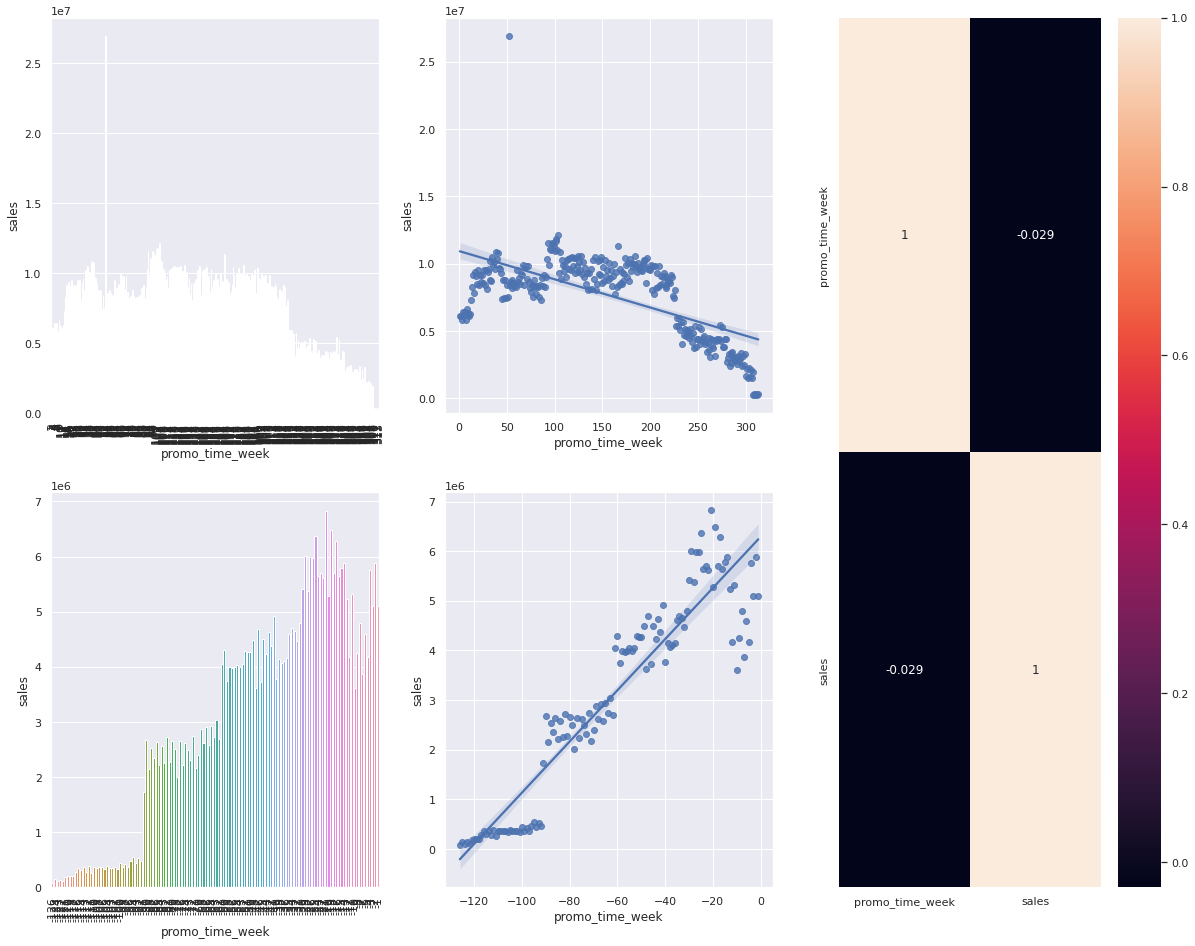

In [46]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()#todas que a promoção já aconteceu ou ainda vai acontecer (numeros positivos e negativos)
#sns.barplot (x='promo_time_week', y='sales', data=aux1); #Muito ruim pra visualizar, dividimos em dois periodos, os que foram vendidos na promoção normal e na promoção extendida
grid = GridSpec( 2, 3 )
plt.subplot( grid[0,0] )

aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );
plt.subplot( grid[0,1] )

sns.regplot( x='promo_time_week', y='sales', data=aux2 );
plt.subplot( grid[1,0] )

aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );
plt.subplot( grid[1,1] )

sns.regplot( x='promo_time_week', y='sales', data=aux3 );
plt.subplot( grid[:,2] ) #para ver a tendencia do grafico, queriamos descobrir se a tendencia é diminuir as vendas e confirmamos ela

sns.heatmap( aux1.corr( method='pearson' ), annot=True ); # determina a força da variavel, para sabermos se é uma variavel boa ou não 

#A hipotese é falsa, pois ela vende regularmente na promoção extendida, depois decai 

### <s> H5. Lojas com mais dias de promoção deveriam vender mais. </s>

In [47]:
#hipotese similar, deveriamos criar nova coluna por dia, vamos realizar no proximo ciclo CRISP 

### H6. Lojas com mais promoções consecutivas deveriam vender mais.

**FALSA** Lojas com mais promocoes consecutivas vendem menos

In [48]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


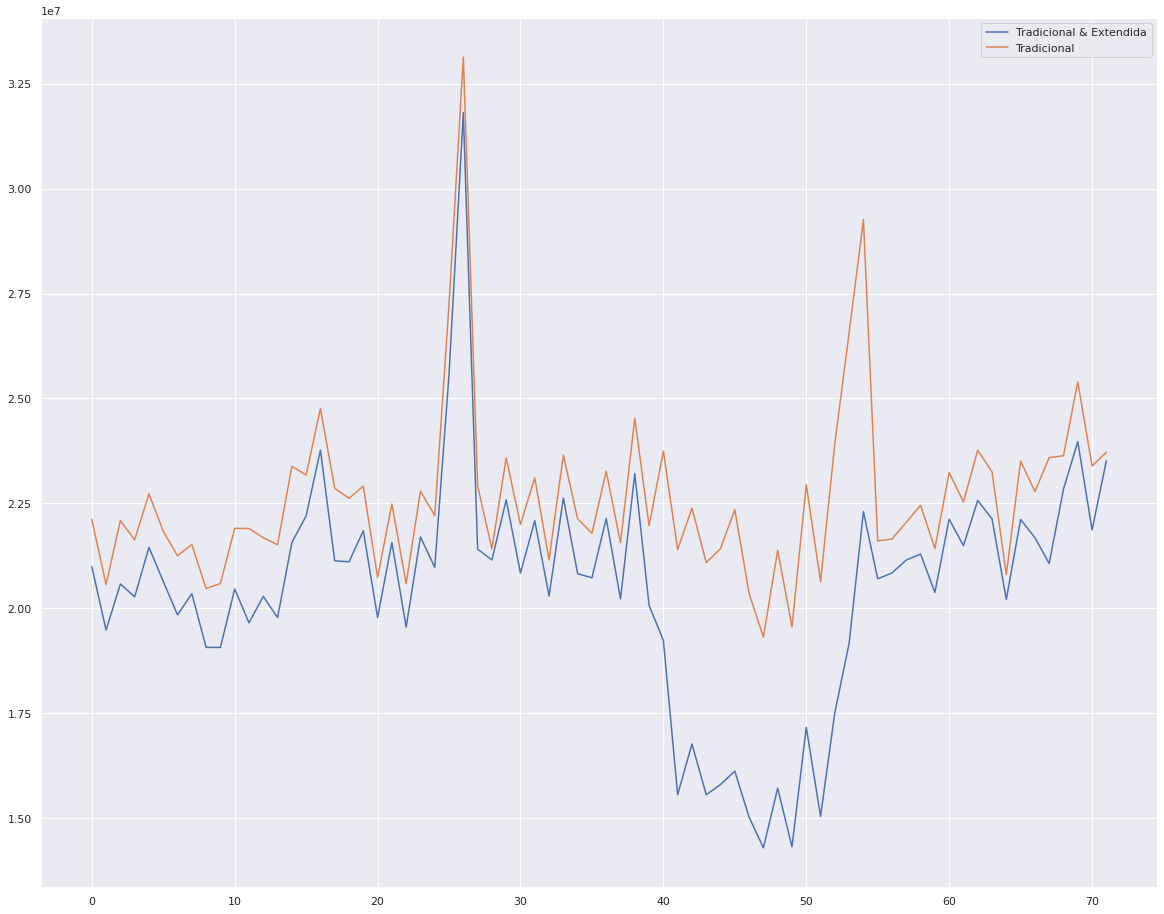

In [49]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index() #queriamos saber se durante o passar do tempo, houve outro                                                                                                                                           comportamento das promoções
ax = aux1.plot()
aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index() #variaveis aparesentam o mesmo comportamente, provavelemnte não serão                                                                                                                               variaveis importantes
aux2.plot( ax=ax )
ax.legend( labels=['Tradicional & Extendida', 'Tradicional']);

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.

**FALSA** Lojas abertas durante o feriado do Natal vendem menos.

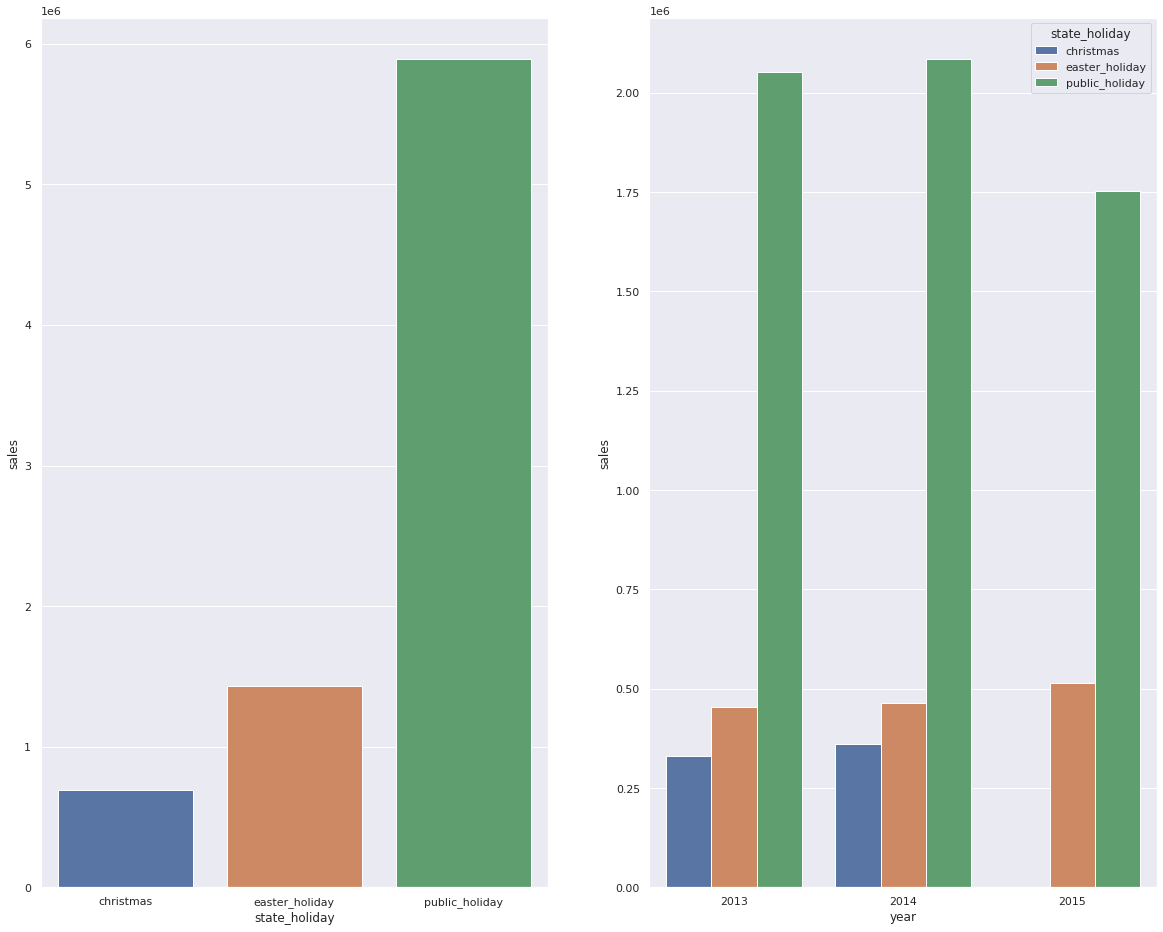

In [50]:
aux = df4[df4['state_holiday'] != 'regular_day'] #filtramos apenas os feriados pois os dias regulares são muito mais massantes

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index() #observamos que as vendas de natal são menores de forma geral e precisamos confirmar se é assim sempre
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).sum().reset_index() #fizemos as vendas por feriado e por ano, confirmamos que o natal as vendas são poucas!
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 ); #não temos o segundo semestre de 2015 
                                                                    #hue determinar o formato que voce quer das suas barras no gŕafico 

### H8. Lojas deveriam vender mais ao longo dos anos.

**FALSA** Lojas vendem menos ao longo dos anos

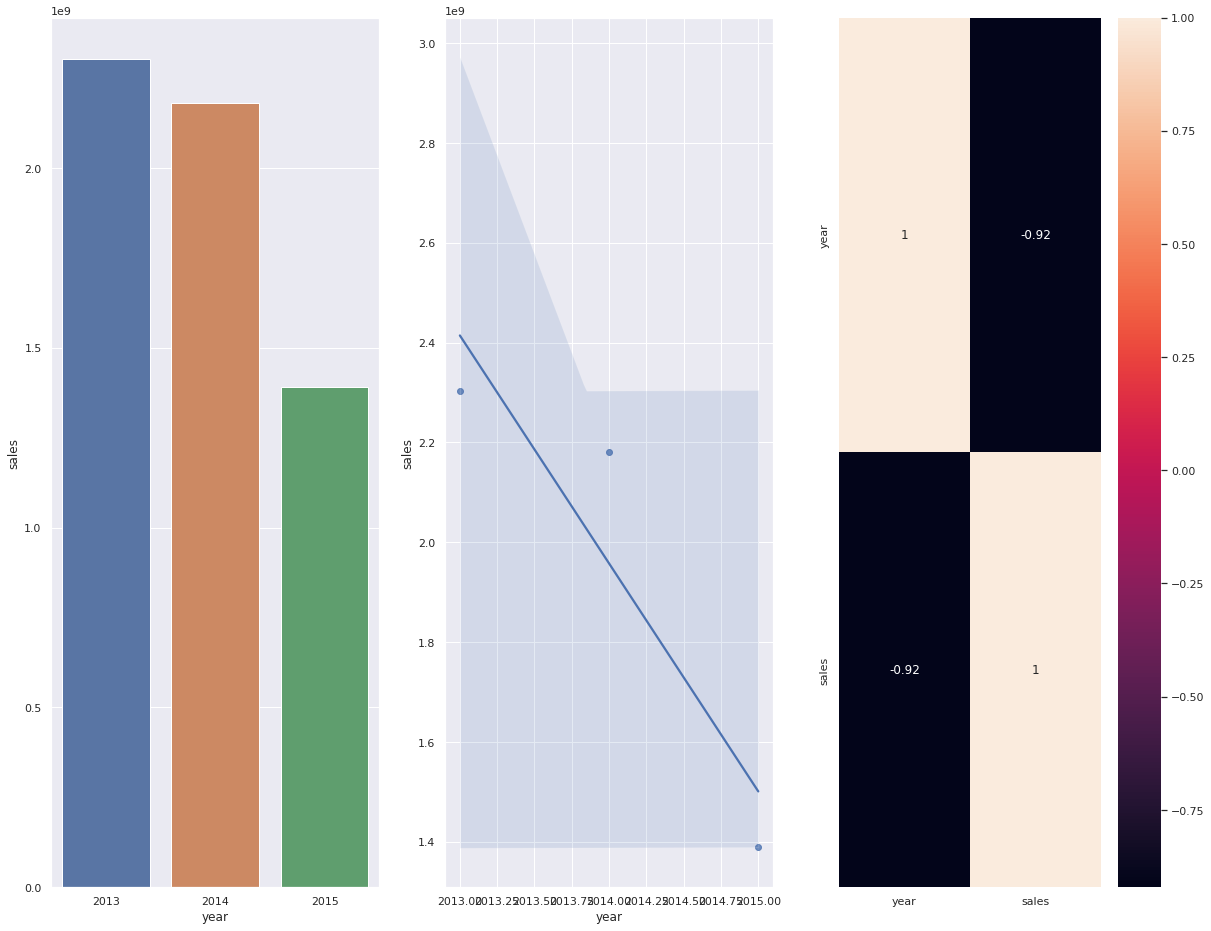

In [51]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index() #agrupamos por anos e fizemos a soma das vendas 

plt.subplot( 1, 3, 1 ) #grafico de barras, observamos que as vendas vem caindo 
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 ) #gráfico que nos retornar a tendência das vendas
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 ) #gráfico para descobrimos a força(correlação) da váriavel (Correlação forte pois o periodo de 2015 não está feixada) 
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H9. Lojas deveriam vender mais no segundo semestre do ano.

**FALSA** Lojas vendem menos no segundo semestre do ano

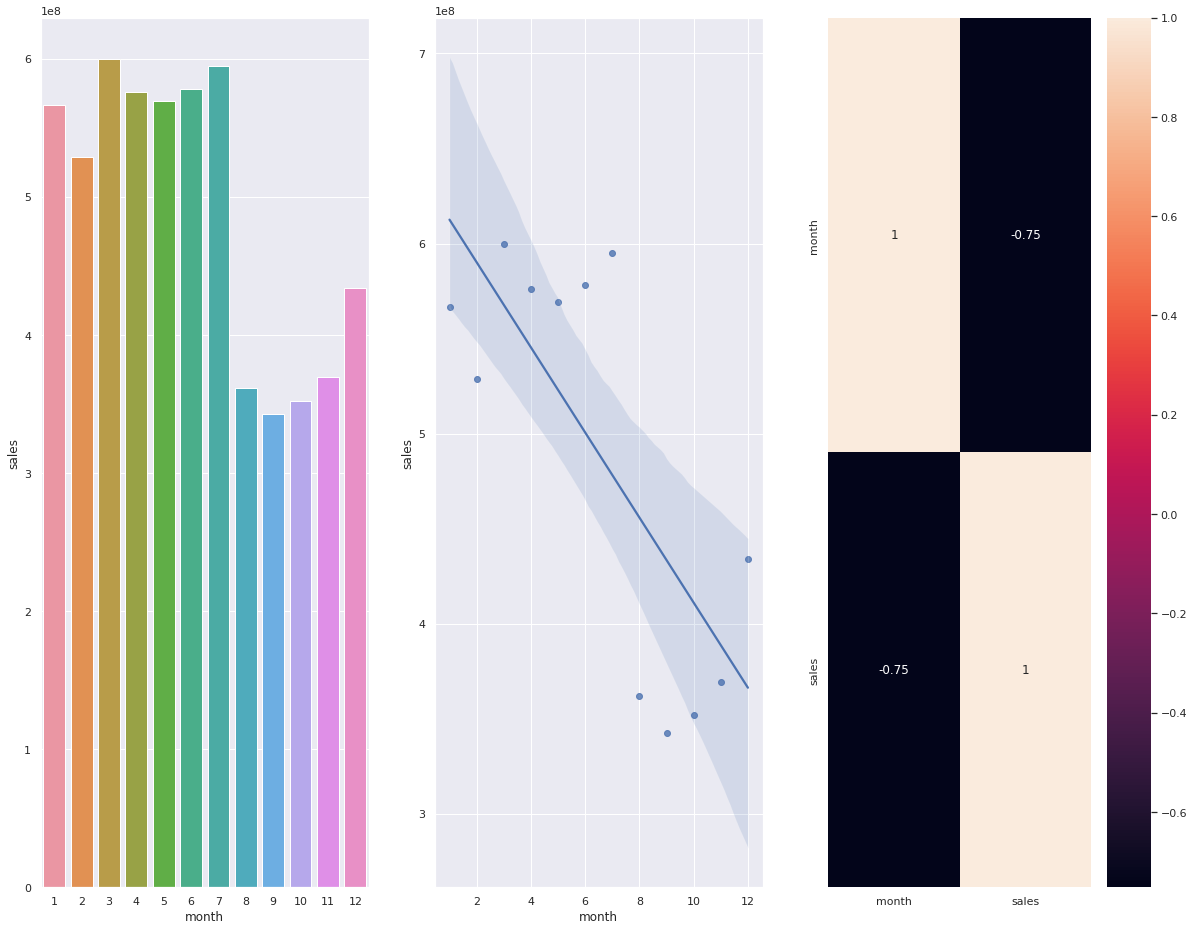

In [52]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index() #agrupamos a soma das vendas por mes

plt.subplot( 1, 3, 1 ) #grafico de barras, observamos que as vendas no segundo semestre caiem drasticamente e volta a vender um pouco mais em dezembro 
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 ) # gráfico que nos tras a tendencia das vendas 
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 ) #gráfico que retorna a carrelação dos meses com as vendas (correlação forte )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.

**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes.

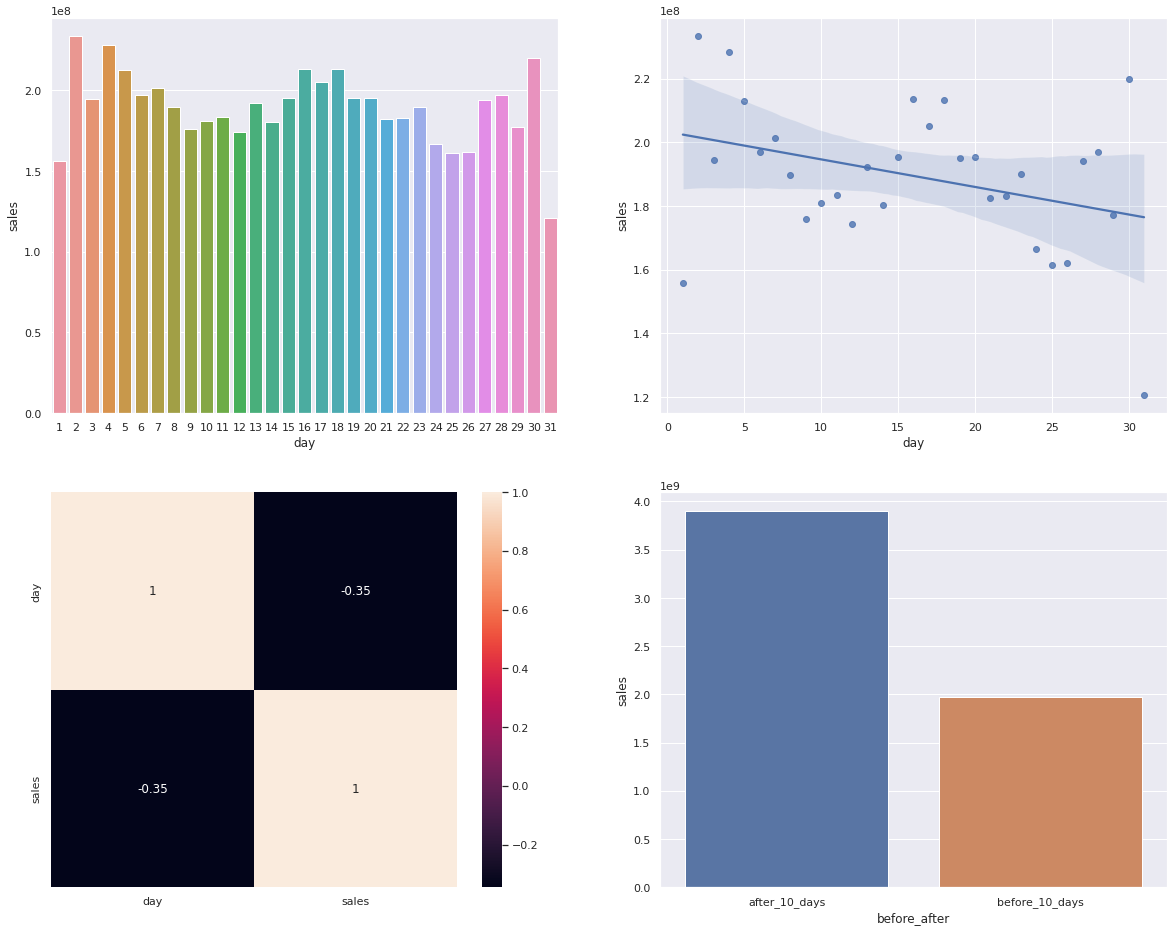

In [53]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index() #agrupamos a soma das vendas por dia 

plt.subplot( 2, 2, 1 ) #grafico de barra das vendas por dia, observamos que as lojas vendem mais deois do dia 
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 ) #grafico de tendencia das vendas
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 ) #correlação dos dias para a venda (correlação não tão forte)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' ) #segração dos dados em dias antes do dia 10 e dias depois do dia 10 
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 ) #grafico em barras de comparação entre as vendas antes e depois do dia 10
sns.barplot( x='before_after', y='sales', data=aux2 );

### H11. Lojas deveriam vender menos aos finais de semana.

**VERDADEIRA** Lojas vendem menos nos final de semana

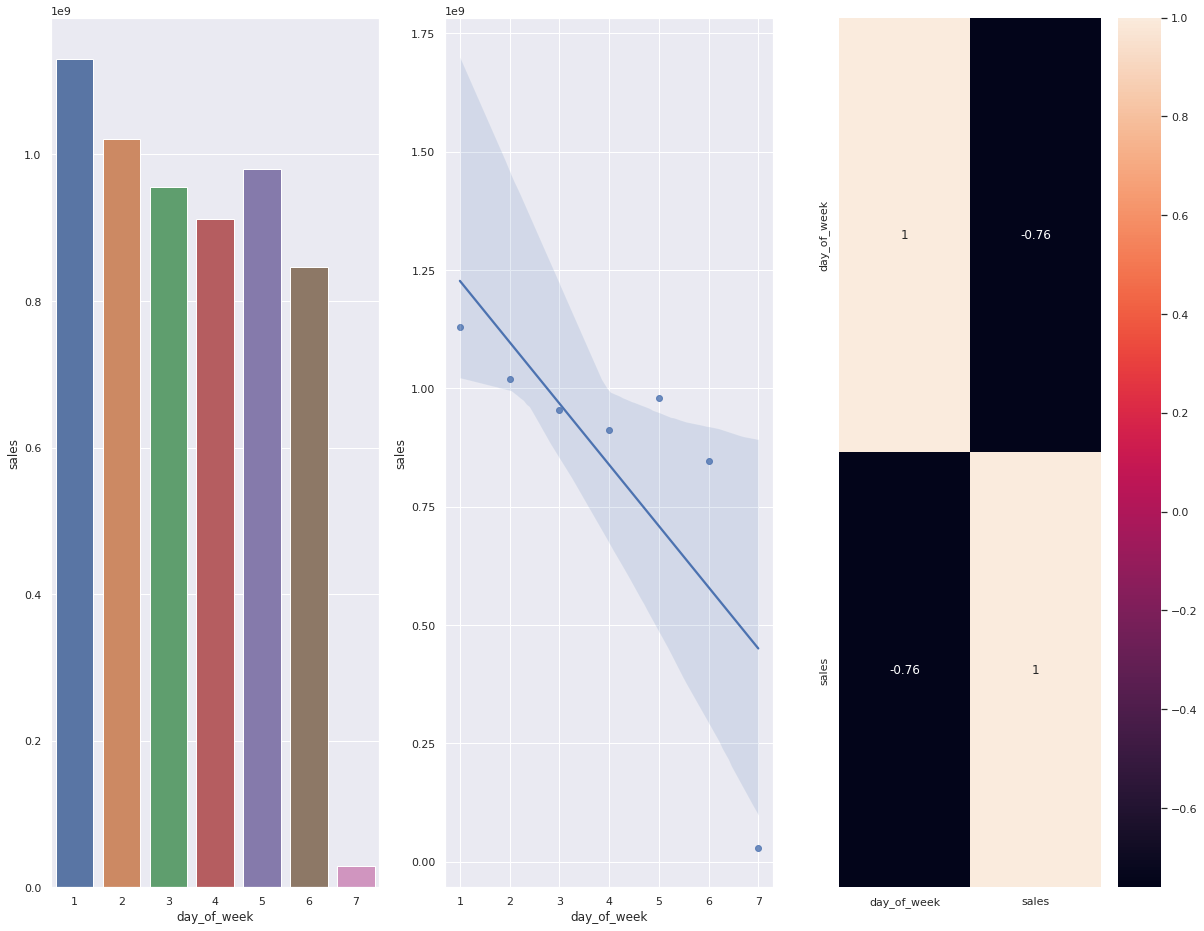

In [54]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index() #agrupamos as vendas por dias da semana

plt.subplot( 1, 3, 1 ) #grafico de barra das vendas por dia, observamos que realmente as vendas no sabado são menores e no domingo caem drasticamente
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 ) #grafico que retorna a tendencia
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 ) #grafico para sabermos a correlação dos dias da semana com as vendas 
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H12. Lojas deveriam vender menos durante os feriados escolares.

**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto.

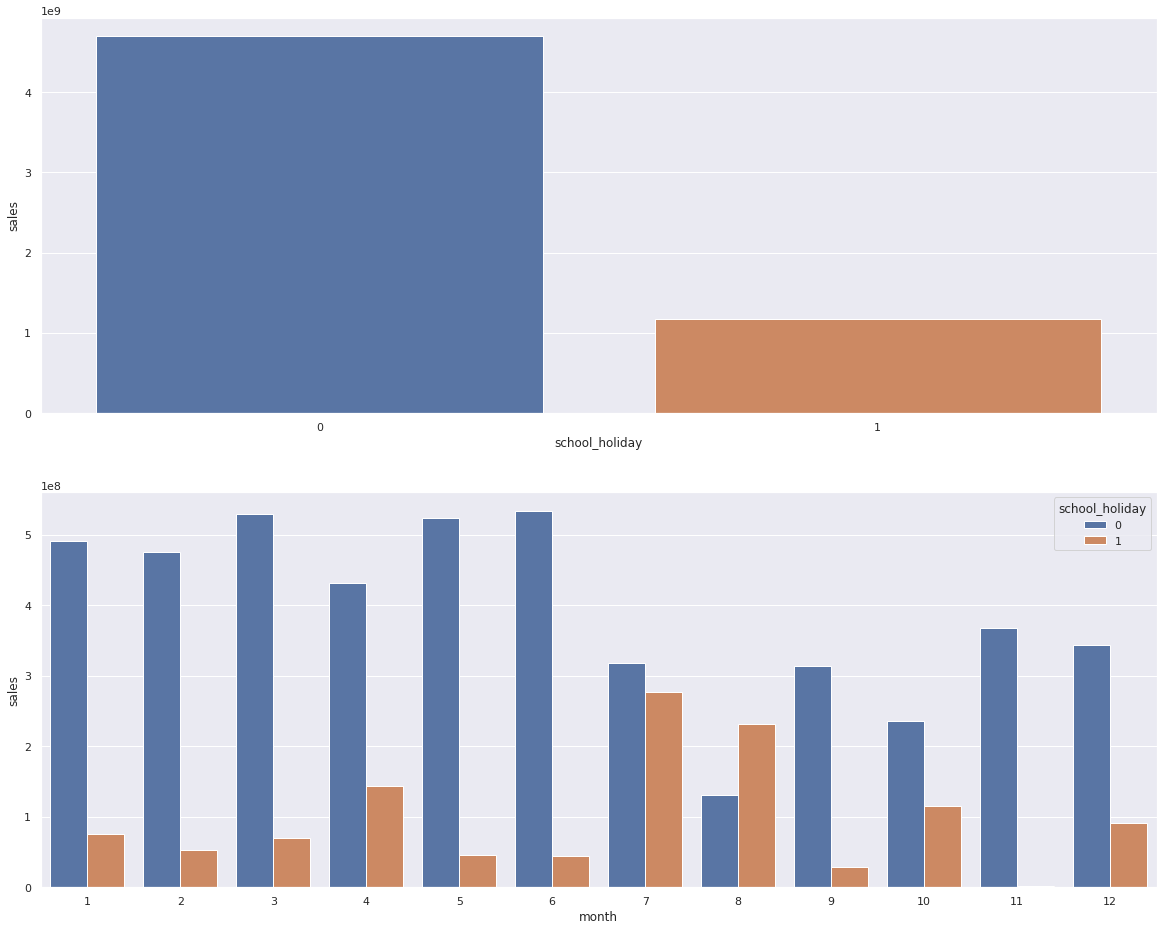

In [55]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index() #agrupamos as vendas por feriados escolares 

plt.subplot( 2, 1, 1 ) #grafico de barras pelos feriados escolares
sns.barplot( x='school_holiday', y='sales', data=aux1 );   

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday'] ).sum().reset_index() #pegamos essa variação por mes para ver o comportamento mensal 

plt.subplot( 2, 1, 2 ) # grafico de barras das vendas em feriados escolares no decorrer dos meses 
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );


### 4.2.1 - Resumo das Hipoteses

In [56]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H6', 'Falsa', 'Baixa'],
['H7', 'Falsa', 'Media'],
['H8', 'Falsa', 'Alta'],
['H9', 'Falsa', 'Alta'],
['H10', 'Verdadeira', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Analise Multivariada

### 4.3.1 Numerical Attributes

<AxesSubplot:>

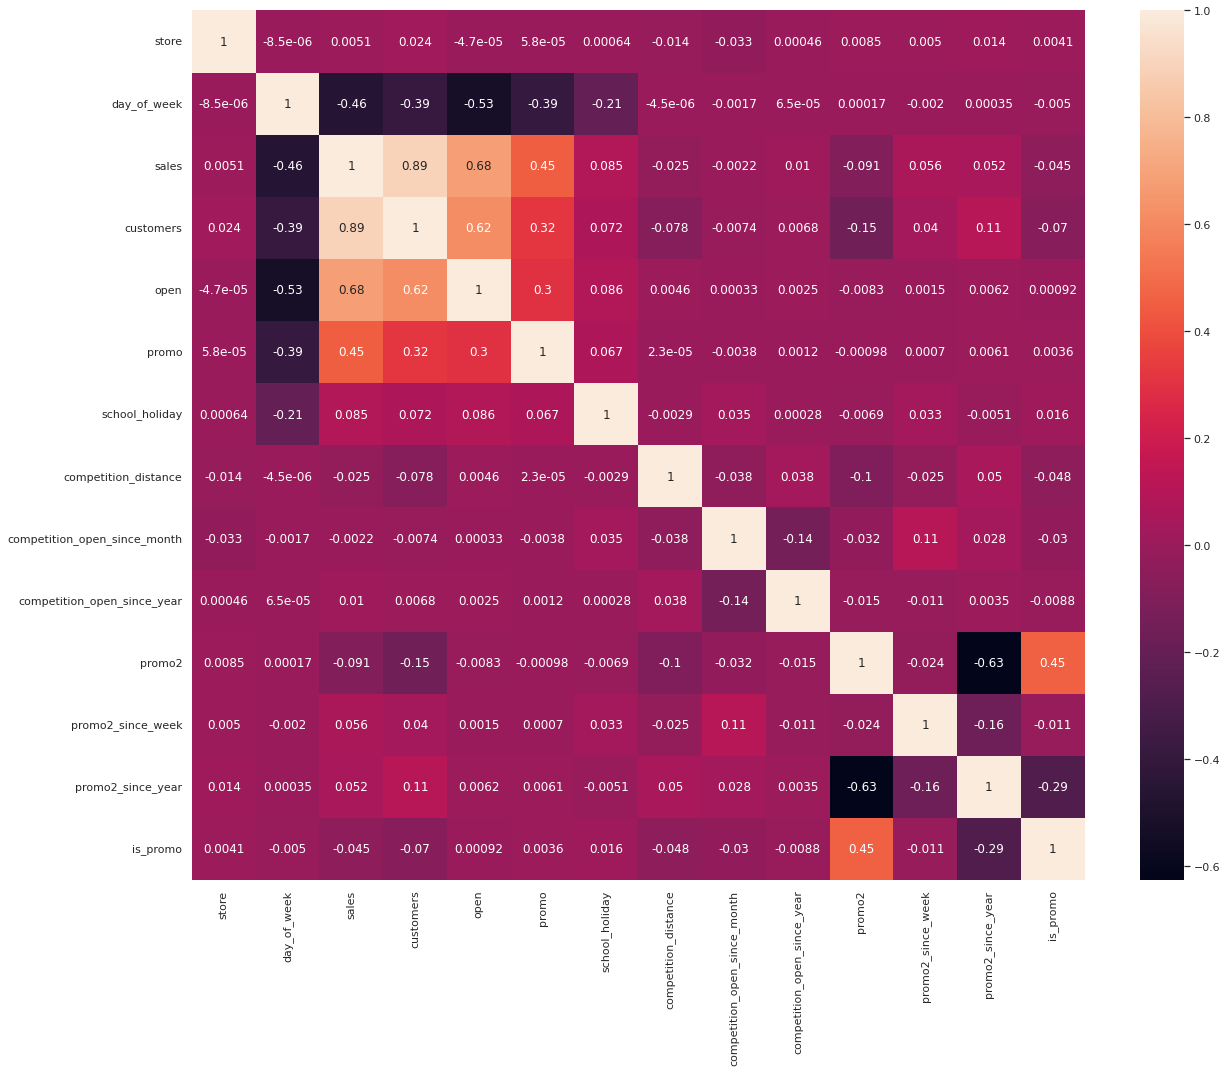

In [57]:
correlation = num_attributes.corr(method = 'pearson') #metodo pearson para ver as correlações entre as variaveis numericas
sns.heatmap (correlation, annot = True) #mais perto do branco (1 positivo) maior a correlação (proporcional)
                                        #mais perto do preto (1 negativo) menor a correlação (inversamente proporcional)
                                        #matriz simetrica, com o corte na diagonal, os lados sao espelhados
        
#pearson teste estatistico pra calcular a correlação entre duas variaveis numericas, não pode ser utilizado em caso de variaveis categoricas

### 4.3.1 Categorical Attributes

In [58]:
#usamos o metodo de cramer v para calcular correlações entre variaveis categoricas, parecido com o de pearson porem para variaveis categoricas 

In [59]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
501150,0,a,a,"Jan,Apr,Jul,Oct",Apr
561390,0,c,a,"Feb,May,Aug,Nov",Feb


In [60]:
#
a = df4.select_dtypes(include ='object')
a #3 colunas

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30
...,...,...,...,...
1016776,public_holiday,b,basic,2013-00
1016827,public_holiday,b,extra,2013-00
1016863,public_holiday,b,extra,2013-00
1017042,public_holiday,b,extra,2013-00


In [61]:
#v = np.sqrt((chi2/n)/(min(k-1,r-1))) # V valor a ser encontrado
                                     #chi2 chama de qui-quadrado obtido no teste de pearson
                                     #n é a soma total das observações
                                     #k numero de colunas do resultado das observações
                                     #r numero de linhas do resultado das observações
                                     
#chi2 ja tem metodo para calcular no python
#chi2 = stats.chi2_contingency (cm)[0] #teste de pearson
                                      #stats é a biblioteca responsável para realizar o teste
                                      #cm tabela de contingẽncia
                                      #primeiro é o resultado do teste (só estamos interessados nesse resultado, por enquanto)
                                      #segundo é p valor
                                      #terceiro é o numero de graus de liberdade
                                      #quarto é a tabela de frequencia
                        
#cm = pd.crosstab(a['state_holiday'], a['store_type']).values #o calculo da tabela de contigencia precisa ser uma matriz, senão retorna 4 numeros
                                                             #tabela de contingência, conta todas as correlações das variaveis categoricas das variaveis passadas (contando o numero de linhas entre elas)
                                                             #no dataset temos 4 linhas que possuem store_type =4 e state_holiday = 'chrstmas'
                                   
#n = cm.sum() #numero da soma do total das observações 
#r, k = cm.shape #pegamos do shape o numero de linhas e colunas

In [62]:
a[(a['state_holiday'] == 'christmas') & (a['store_type'] == 'a')] #teste para ver as 4 linhas que possuem as condiçoes mencionadas a cima 

,state_holiday,store_type,assortment,year_week
241499,christmas,a,extended,2014-51
241977,christmas,a,extended,2014-51
616339,christmas,a,extended,2013-51
616908,christmas,a,extended,2013-51


In [63]:
#v = np.sqrt((chi2/n)/(min(k-1,r-1)))  #v de cramer vai de 0 a 1 (sem numeros negativos), quanto mais perto do 0 menor a correlação e quanto mais perto do 1 maior a correlação

In [64]:
#USADO NA AREA DE HELP FUNCTIONS 

#apos aprender como é calculado, faremos uma função fazer isso entre todos as variaveis
#def cramer_v (x,y):
#    cm = pd.crosstab(x,y).values
#    n = cm.sum()
    
#    r , k = cm.shape 
    
#    chi2 = stats.chi2_contingency (cm)[0]
#    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1)) #corr = as variaveis com o corr (corrigidas), precisam dessa correção pq o v de cramer tem um alto vies em relação ao extimador(ele sempre tende a                                                  extimar um numero muito maior do que ele realmente é na associação)
    
#    kcorr = k - (k-1)**2/(n-1)
#    rcorr = r - (r-1)**2/(n-1)
    
#    v = np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
    
#    return v
#agora basta passar as colunas como argumento da função onde será calculada o grau de correlação 

#cramer_v(a['state_holiday'], a['store_type']) # o resultado manteve o valor, mas manteremos a correção para caso em que o resultado altera 

In [65]:
a1 = cramer_v(a['state_holiday'], a['state_holiday']) #criação da matriz para vermos todas as correlações 
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame ({'state_holiday': [a1,a2,a3],
                   'store_type': [a4,a5,a6],
                   'assortment': [a7,a8,a9]})
d = d.set_index (d.columns) #todas as colunas como indices da matriz, para os indices e as colunas terem os mesmos nomes 
d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


<AxesSubplot:>

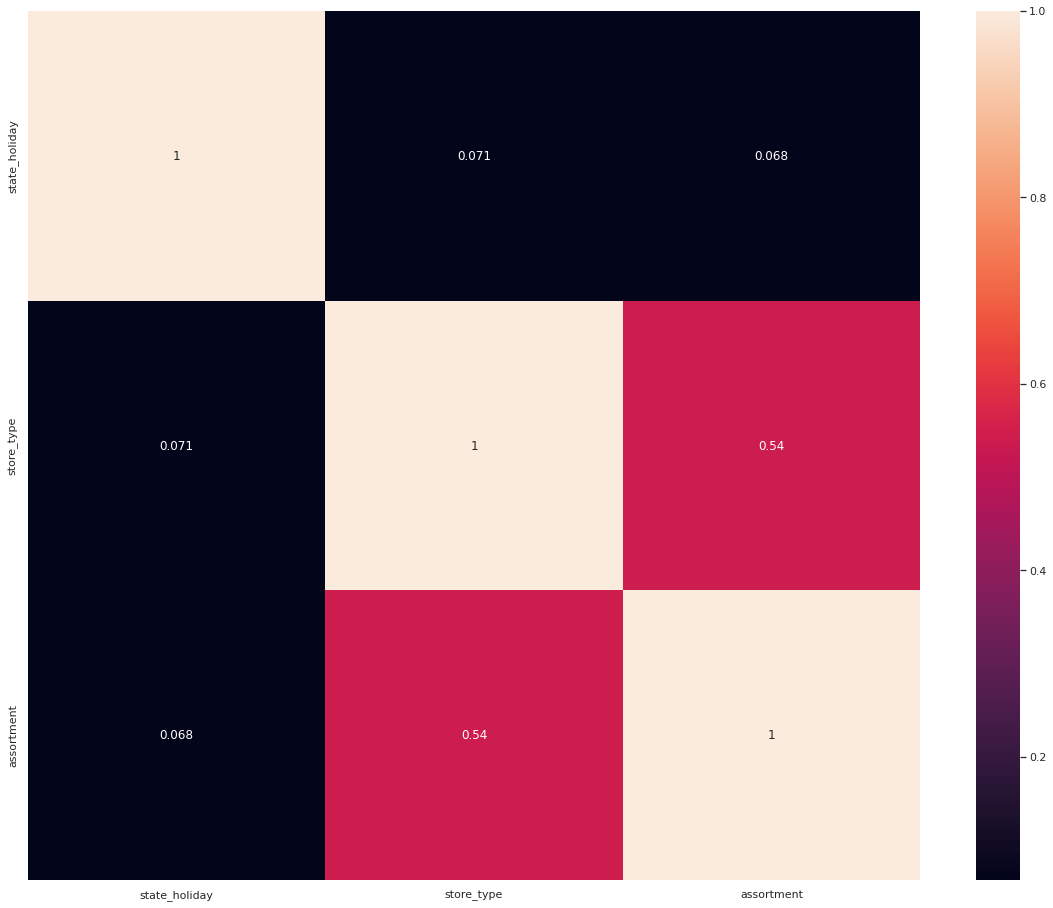

In [66]:
sns.heatmap(d, annot= True) #mapa que tras as correlações das variaveis, neste caso categoricas 

<AxesSubplot:>

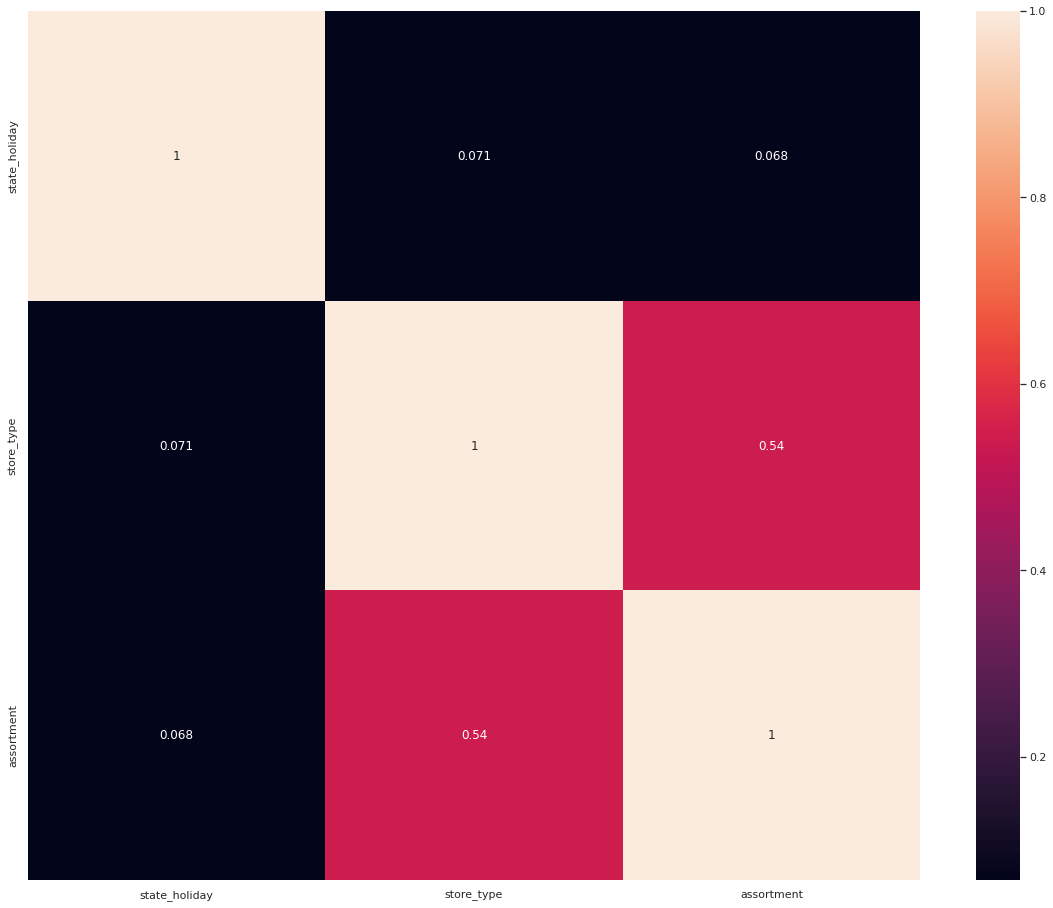

In [67]:
#CALCULAR O MAPA DE CORRELAÇÕES DE FORMA DIRETA 

# only categorical data
a = df4.select_dtypes( include='object' )
# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )
# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
'store_type': [a4, a5, a6],
'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

# 5.0 PASSO 05 - PREPARACAO DOS DADOS

In [121]:
df5 = df4.copy()

## 5.1 Normalização 

In [69]:
#Não haverá normalização pois ao observamos a distribuição das variaveis na seção 4.2 não existe distribuição normal

## 5.2 Rescalling

In [70]:
a = df5.select_dtypes(include = ['int64', 'float64']) #seleção das variaveis numericas

In [71]:
a #analisando as variaveis que aplicaremos o rescalling

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_week,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,3375,0,1,150.0,9,2006,0,1,2013,0,2013,1,1,1,77,0
1016827,733,2,10765,0,1,860.0,10,1999,0,1,2013,0,2013,1,1,1,161,0
1016863,769,2,5035,0,1,840.0,1,2013,1,48,2012,1,2013,1,1,1,0,6
1017042,948,2,4491,0,1,1430.0,1,2013,0,1,2013,0,2013,1,1,1,0,0


/home/diego/.pyenv/versions/3.10.1/envs/DataScienceEmProducao/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='competition_distance'>

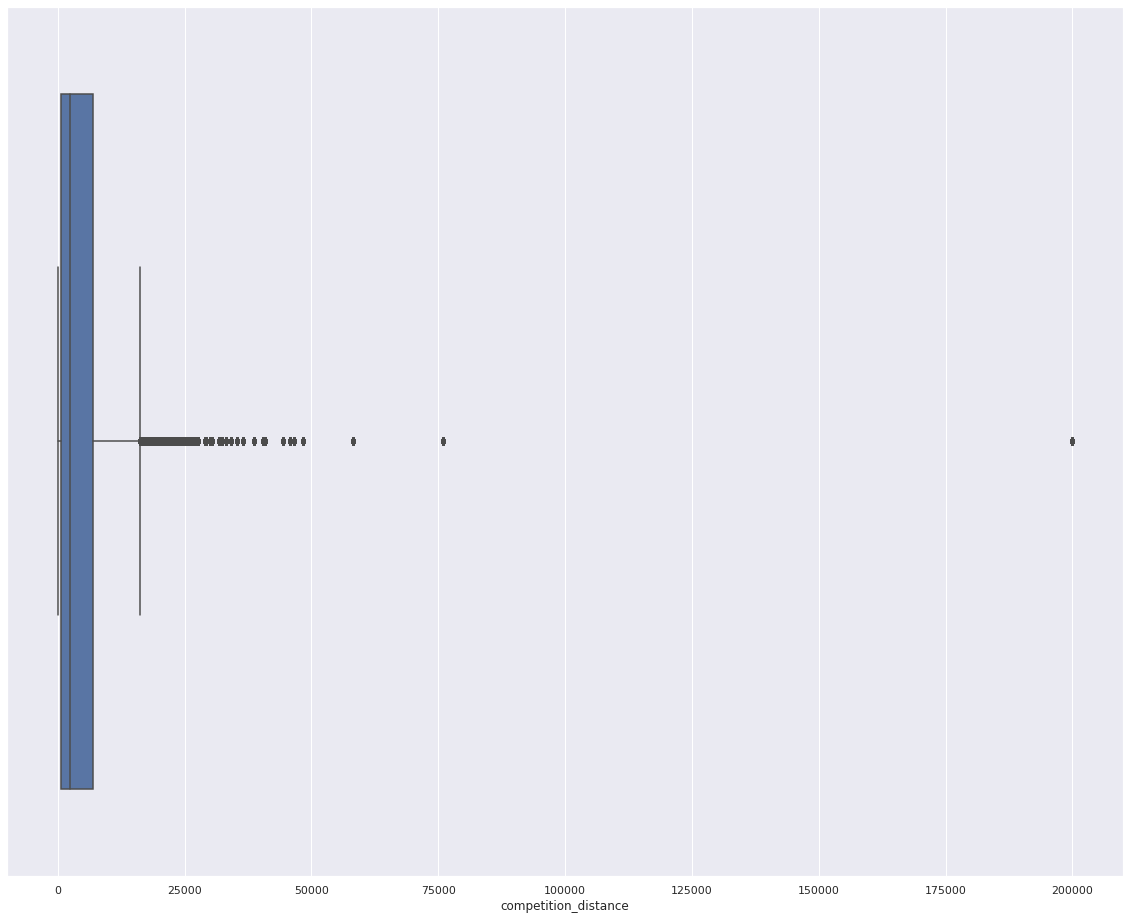

In [72]:
sns.boxplot (df5['competition_distance'])

/home/diego/.pyenv/versions/3.10.1/envs/DataScienceEmProducao/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='competition_time_month'>

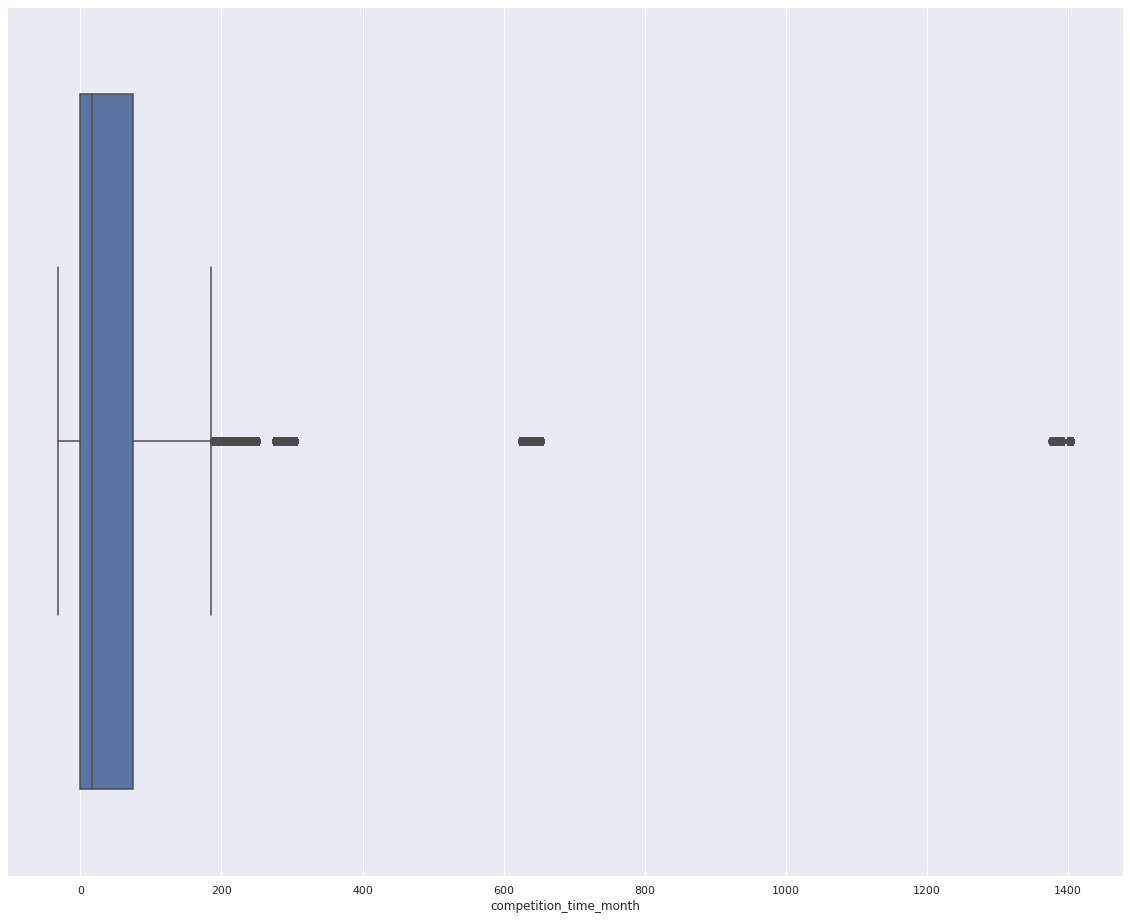

In [73]:
sns.boxplot (df5['competition_time_month'])

/home/diego/.pyenv/versions/3.10.1/envs/DataScienceEmProducao/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='promo_time_week'>

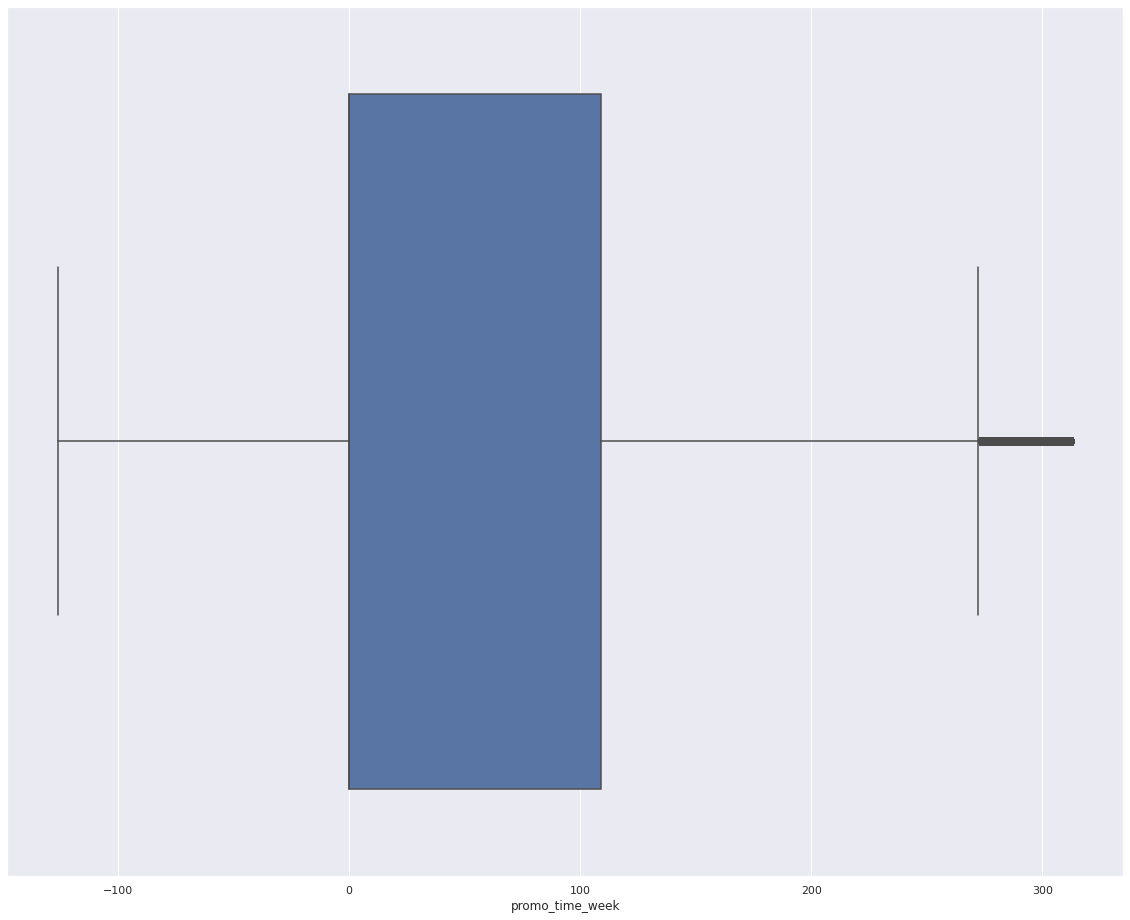

In [74]:
sns.boxplot (df5['promo_time_week']) #obervamos que não tem outliers tão relevantes, arriscaremos o min max scaler

/home/diego/.pyenv/versions/3.10.1/envs/DataScienceEmProducao/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year'>

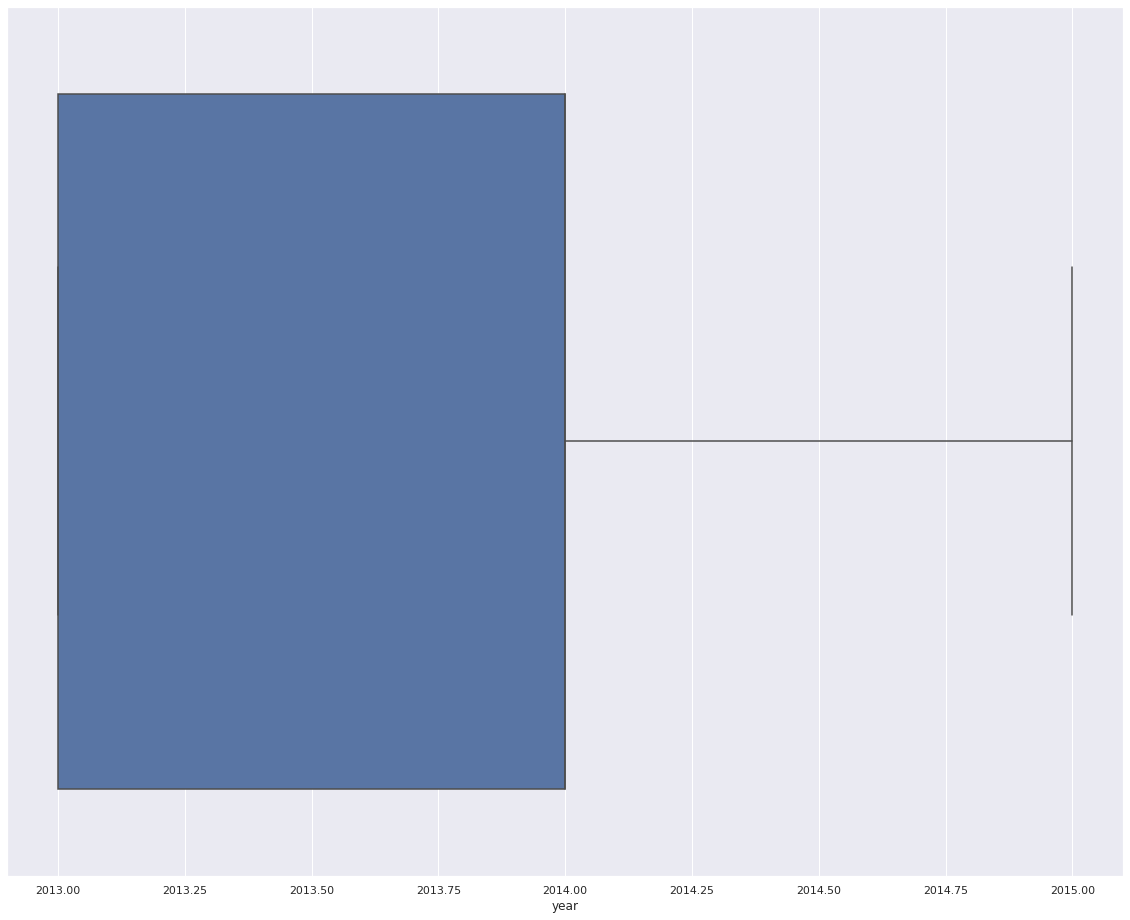

In [75]:
sns.boxplot (df5['year']) #sem outliers

In [125]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance - robust scaler (outliers) obervamos no boxplot
df5['competition_distance'] = rs.fit_transform (df5[['competition_distance']].values) #metodo que encontra os parametros da formula e aplica nos dados (os parametros são os quartis Q1 e Q37
pickle.dump(rs , open('/home/diego/repos/DataScience-em-Producao/parameter/competition_distance_scaler.pkl','wb')) #salvando nossas transformações

#competition_time_month -- robust scaler (outliers) obervamos no boxplot
df5['competition_time_month'] = rs.fit_transform (df5[['competition_time_month']].values)
pickle.dump(rs , open('/home/diego/repos/DataScience-em-Producao/parameter/competition_time_month_scaler.pkl','wb'))

#promo_time_week - MinMaxScaler, pois observamos que não tem outliers tão relevantes
df5['promo_time_week'] = mms.fit_transform (df5[['promo_time_week']].values) #realizado da mesma forma, só muda o metodo 
pickle.dump(mms , open('/home/diego/repos/DataScience-em-Producao/parameter/promo_time_week_scaler.pkl','wb'))

# year 
df5['year'] = mms.fit_transform (df5[['year']].values) #sem outilers
pickle.dump(mms , open('/home/diego/repos/DataScience-em-Producao/parameter/year_scaler.pkl','wb'))

## 5.3 Transforms

### 5.3.1 Encoding 

In [77]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_week,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [123]:
#state_holiday - usaremos o One Hot Encoding, pois se trata de estados, funciona de uma forma no feriado e de outra em dias regulares
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns = ['state_holiday']) #metodo do pandas para aplicar o metodo One Hot Encoding na variavel categorica
                                                                                 #passamos o dataframe, o nome a ficar na coluna e a coluna que queremos aplicar 

#store_type - usaremos o Label Encoding, pois não sabemos se tem alguma comparação de tamanho ou ordem, mudaremos para numeros arbritarios
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type']) #metodo da biblioteca pandas para aplicar o Label Encoding em todo dataframe nas coluna passada no argumento 
pickle.dump(le , open('/home/diego/repos/DataScience-em-Producao/parameter/store_type_scaler.pkl','wb'))



#assortment - Order Encoding, pois manteremos a ordem que elas tem uma com a outra
assortment_dict = {'basic': 1, 'extra':2, 'extended': 3} #dicionario para criar os indices numericos
df5['assortment'] = df5['assortment'].map(assortment_dict) #função que aplica a troca do nome pelo numero explictado, com a ordem que observamos


#como usamos o CRISP, usaremos o metodo pelo nosso felling, no proximo ciclo, usaremos outros tipos de encoding. O importante é entregar resultado raípdo, no proximo ciclo vamos melhorando.
# nada impede de usar o Targe Encoding em tudo (pela média de vendas)

In [79]:
df5['assortment'].drop_duplicates() #obversamos uma ordem entre elas

0      1
3      3
258    2
Name: assortment, dtype: int64

In [80]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_week,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### 5.3.2 Response Variable Transformation


In [81]:
df5['sales'] = np.log1p(df5['sales']) # Logarathm Transformation

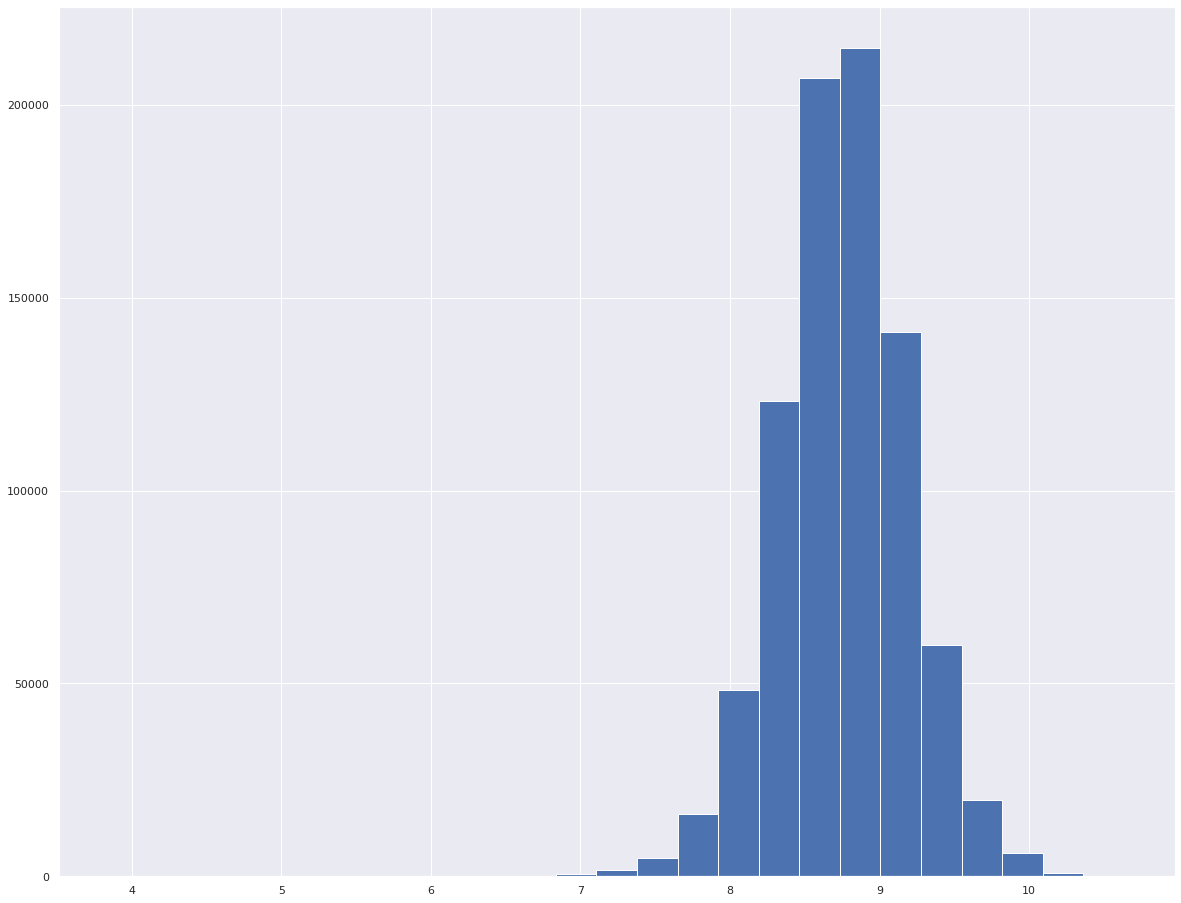

In [82]:
df5['sales'].hist( bins = 25);

In [83]:
#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12))) #pegando o seno para fazer o metodo ser ciclico
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12))) #pegando o cosseno para fazer o metodo ser ciclico
#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30))) #pegando o seno para fazer o metodo ser ciclico
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30))) #pegando o cosseno para fazer o metodo ser ciclico

#week_of_year
df5['week_of_week_sin'] = df5['week_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/52))) #pegando o seno para fazer o metodo ser ciclico
df5['week_of_week_cos'] = df5['week_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/52))) #pegando o cosseno para fazer o metodo ser ciclico

#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7))) #pegando o seno para fazer o metodo ser ciclico
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7))) #pegando o cosseno para fazer o metodo ser ciclico

In [84]:
df5

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_week,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_week_sin,week_of_week_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,8.124447,0,1,1,1,-0.351613,9,2006,0,1,2013,0,0.0,1,1,1,2013-00,2006-09-01,0.824324,2012-12-31,0.287016,0,0,1,0,0.5,0.866025,0.207912,0.978148,0.120537,0.992709,0.974928,-0.222521
1016827,733,2,2013-01-01,9.284148,0,1,1,2,-0.237097,10,1999,0,1,2013,0,0.0,1,1,1,2013-00,1999-10-01,1.959459,2012-12-31,0.287016,0,0,1,0,0.5,0.866025,0.207912,0.978148,0.120537,0.992709,0.974928,-0.222521
1016863,769,2,2013-01-01,8.524367,0,1,1,2,-0.240323,1,2013,1,48,2012,1,0.0,1,1,1,2013-00,2013-01-01,-0.216216,2012-11-19,0.300683,0,0,1,0,0.5,0.866025,0.207912,0.978148,0.120537,0.992709,0.974928,-0.222521
1017042,948,2,2013-01-01,8.410053,0,1,1,2,-0.145161,1,2013,0,1,2013,0,0.0,1,1,1,2013-00,2013-01-01,-0.216216,2012-12-31,0.287016,0,0,1,0,0.5,0.866025,0.207912,0.978148,0.120537,0.992709,0.974928,-0.222521


# 6.0 PASSO 06 - FEATURE SELECTION

In [85]:
df6 = df5.copy()

In [86]:
df6

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_week,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_week_sin,week_of_week_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,8.124447,0,1,1,1,-0.351613,9,2006,0,1,2013,0,0.0,1,1,1,2013-00,2006-09-01,0.824324,2012-12-31,0.287016,0,0,1,0,0.5,0.866025,0.207912,0.978148,0.120537,0.992709,0.974928,-0.222521
1016827,733,2,2013-01-01,9.284148,0,1,1,2,-0.237097,10,1999,0,1,2013,0,0.0,1,1,1,2013-00,1999-10-01,1.959459,2012-12-31,0.287016,0,0,1,0,0.5,0.866025,0.207912,0.978148,0.120537,0.992709,0.974928,-0.222521
1016863,769,2,2013-01-01,8.524367,0,1,1,2,-0.240323,1,2013,1,48,2012,1,0.0,1,1,1,2013-00,2013-01-01,-0.216216,2012-11-19,0.300683,0,0,1,0,0.5,0.866025,0.207912,0.978148,0.120537,0.992709,0.974928,-0.222521
1017042,948,2,2013-01-01,8.410053,0,1,1,2,-0.145161,1,2013,0,1,2013,0,0.0,1,1,1,2013-00,2013-01-01,-0.216216,2012-12-31,0.287016,0,0,1,0,0.5,0.866025,0.207912,0.978148,0.120537,0.992709,0.974928,-0.222521


## 6.1 Split dataframe into training and test dataset

In [87]:
#vamos dropar as colunas das quais foram derivadas para criação de novas colunas atraves da analise do dataset

cols_drop = ['day_of_week','week_of_week','day','month', 'promo_since','competition_since','year_week']
df6 = df6.drop (cols_drop, axis=1)

In [88]:
#para aplicar o metodo, precisamos separar os dataset em dois, um para treino e outro para teste. Por se tratar de um dataset de vendas diarias (temporal), que tem passagem de tempo, devemos tomar o cuidado para não termos dados nos dois datasets, que estão no "passado" e "futuro", pois o algoritimo não vai estar sendo treinado, ele vai estar gravando esses dados, fazendo com que tenha uma faixa de acertos muito alta (over fit). 
#Como as vendas são diarias e que queremos realizar a previsão das proximas 6 semanas, separemos o dataset da seguinte forma:
# vendas das ultimas 6 semanas como o dataset de teste.
# vendas do primeiro dia de registro até antes das ultimas 6 semana o dataset como treino.

In [89]:
df6[['store','date']].groupby('store').min().reset_index() #todas as lojas começaram a vender no mesmo dia

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
...,...,...
1110,1111,2013-01-02
1111,1112,2013-01-02
1112,1113,2013-01-02
1113,1114,2013-01-02


In [90]:
df6[['store','date']].groupby('store').max().reset_index() # temos registros de vendas até o mesmo dia de todas as lojas

,store,date
0,1,2015-07-31
1,2,2015-07-31
2,3,2015-07-31
3,4,2015-07-31
4,5,2015-07-31
...,...,...
1110,1111,2015-07-31
1111,1112,2015-07-31
1112,1113,2015-07-31
1113,1114,2015-07-31


In [91]:
df6[['store','date']].groupby('store').max().reset_index().loc[0, 'date'] - datetime.timedelta( days = 6*7) #realizamos a subtração das 6 semanas atraves do metodo explicitado da biblioteca datetime

Timestamp('2015-06-19 00:00:00')

In [92]:
x_train = df6[df6['date'] < '2015-06-19'] #dataset a ser treinado
y_train = x_train['sales'] #variavel resposta

x_test = df6[df6['date'] >= '2015-06-19'] #dataset a ser testado 
y_test = x_test['sales']#variavel resposta 

print('Training Min Date: {}' .format (x_train['date'].min())) #conferindo se a nossa segração está certa
print('Training Max Date: {}' .format (x_train['date'].max()))


print('\nTest Min Date: {}' .format (x_test['date'].min()))
print('Test Max Date: {}' .format (x_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [97]:
x_train #Possui duas variaveis que nao podemos usar, pois são dados de treino (date, sales)

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_week_sin,week_of_week_cos,day_of_week_sin,day_of_week_cos
47945,1,2015-06-18,8.443762,1,0,2,1,-0.170968,9,2008,0,25,2015,0,1.0,0.891892,0.287016,0,0,0,1,1.224647e-16,-1.000000,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47946,2,2015-06-18,8.547722,1,0,0,1,-0.283871,11,2007,1,13,2010,0,1.0,1.027027,0.908884,0,0,0,1,1.224647e-16,-1.000000,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47947,3,2015-06-18,8.927712,1,0,0,1,1.903226,12,2006,1,14,2011,0,1.0,1.189189,0.788155,0,0,0,1,1.224647e-16,-1.000000,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47948,4,2015-06-18,9.091669,1,0,2,3,-0.275806,9,2009,0,25,2015,0,1.0,0.729730,0.287016,0,0,0,1,1.224647e-16,-1.000000,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47949,5,2015-06-18,8.502080,1,0,0,1,4.448387,4,2015,0,25,2015,0,1.0,-0.189189,0.287016,0,0,0,1,1.224647e-16,-1.000000,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2013-01-01,8.124447,0,1,1,1,-0.351613,9,2006,0,1,2013,0,0.0,0.824324,0.287016,0,0,1,0,5.000000e-01,0.866025,0.207912,0.978148,0.120537,0.992709,0.974928,-0.222521
1016827,733,2013-01-01,9.284148,0,1,1,2,-0.237097,10,1999,0,1,2013,0,0.0,1.959459,0.287016,0,0,1,0,5.000000e-01,0.866025,0.207912,0.978148,0.120537,0.992709,0.974928,-0.222521
1016863,769,2013-01-01,8.524367,0,1,1,2,-0.240323,1,2013,1,48,2012,1,0.0,-0.216216,0.300683,0,0,1,0,5.000000e-01,0.866025,0.207912,0.978148,0.120537,0.992709,0.974928,-0.222521
1017042,948,2013-01-01,8.410053,0,1,1,2,-0.145161,1,2013,0,1,2013,0,0.0,-0.216216,0.287016,0,0,1,0,5.000000e-01,0.866025,0.207912,0.978148,0.120537,0.992709,0.974928,-0.222521


In [96]:
#training and test dataset for Boruta
x_train_n = x_train.drop(['date', 'sales'], axis=1).values #como eu quero passar um numpy e não um dataframe usamos o .values
y_train_n = y_train.values.ravel() #ravel coloca tudo dentro de um vetor

#define RandomForestRegressor
rf = RandomForestRegressor(n_jobs = -1) # argumento para fazer com que todos os jobs use todos os cores da maquina e faça todo processamento em paralelo, ser mais rapido

#define boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose = 2, random_state =42).fit(x_train_n, y_train_n) 
#precisamos passar os seguintes argumentos: 
#1 - modelo que vamos usar pra poder fazer a seleção de feature (randow forest escolhido)
#2 - numero de estimativas (auto é escolhido, para o proprio modelo decidir o numero de 'arvores' achar necessário para fazer a ramificação)
#3 - verbose = 2, para ver o que ta acontecendo ( a demora é grande)
#4 - random state= 42, pois ele seleciona de forma aleatoria para depois criar o restante, toda vez q ele selecionar a variavel aleatoria, ele parte da mesma inicialização pode ser qualquer numero, só precisar ser estabelecido
#.fit metodo que realiza o treino
# dados que serão treinados, não pode ser passado um dataframe, precisa ser um vetor(numpy) por isso o _n

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1 Best Features from Boruta

In [22]:
#Iteration: 	1 / 100 iteração, 100 é o maximo de tentativas 
#Confirmed: 	0 quatidade de variaveis relevantes
#Tentative: 	27 tentativas
#Rejected: 	0 variaveis não relevantes

In [80]:
cols_selected = boruta.support_.tolist() #valor do ranked que ele fez atravez do valor da relevancia, fornece numeros para sabermos classificar os ranqueamentos


#best features
x_train_fs = x_train.drop(['date', 'sales'], axis=1) #axis = 1 sempre pra dropar as colunas linha por linha(coluna inteira)
                                                     #linha para dropas as colunas do x_train, pois não podemos usar o x_train_n por não ser mais um dataset
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.tolist() #forma de ver os nome, pois o boruta retorna indices, realizamos essa linha para termos acesso aos nome
                                                                          #queremos só as colunas e em formato de lista
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta)) # para vermos quais colunas foram dropadas (rejeitadas), usamos essa função do numpy para fazer o comparativo entre os dois dataset, em quais colunas eles tem de diferente

NameError: name 'boruta' is not defined

In [ ]:
cols_selected_boruta

In [ ]:
cols_not_selected_boruta

## 6.3 Manual Feature Selection

In [93]:
cols_selected_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'month_sin',
     'month_cos',
     'day_sin',
     'day_cos',
     'week_of_week_cos',
     'week_of_week_sin',
     'day_of_week_sin',
     'day_of_week_cos']

# columns to add  colunas que foram tiradas do dataset para fazer o treinamento do boruta mas precisam estar na treinamento de Ml
feat_to_add = ['date', 'sales']

#final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [94]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_week_cos',
 'week_of_week_sin',
 'day_of_week_sin',
 'day_of_week_cos']

# 7.0 PASSO 07 - MACHINE LEARNING MODELLING

In [95]:
X_train = x_train[cols_selected_boruta] #não adicionamos o date e o sales no primeiro momento
X_test = x_test[cols_selected_boruta] #selecionados pelas melhores variaveis do boruta

In [96]:
X_train

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,month_sin,month_cos,day_sin,day_cos,week_of_week_cos,week_of_week_sin,day_of_week_sin,day_of_week_cos
47945,1,1,2,1,-0.170968,9,2008,0,25,2015,0.891892,0.287016,1.224647e-16,-1.000000,-0.587785,-0.809017,-0.992709,0.120537,-0.433884,-0.900969
47946,2,1,0,1,-0.283871,11,2007,1,13,2010,1.027027,0.908884,1.224647e-16,-1.000000,-0.587785,-0.809017,-0.992709,0.120537,-0.433884,-0.900969
47947,3,1,0,1,1.903226,12,2006,1,14,2011,1.189189,0.788155,1.224647e-16,-1.000000,-0.587785,-0.809017,-0.992709,0.120537,-0.433884,-0.900969
47948,4,1,2,3,-0.275806,9,2009,0,25,2015,0.729730,0.287016,1.224647e-16,-1.000000,-0.587785,-0.809017,-0.992709,0.120537,-0.433884,-0.900969
47949,5,1,0,1,4.448387,4,2015,0,25,2015,-0.189189,0.287016,1.224647e-16,-1.000000,-0.587785,-0.809017,-0.992709,0.120537,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,0,1,1,-0.351613,9,2006,0,1,2013,0.824324,0.287016,5.000000e-01,0.866025,0.207912,0.978148,0.992709,0.120537,0.974928,-0.222521
1016827,733,0,1,2,-0.237097,10,1999,0,1,2013,1.959459,0.287016,5.000000e-01,0.866025,0.207912,0.978148,0.992709,0.120537,0.974928,-0.222521
1016863,769,0,1,2,-0.240323,1,2013,1,48,2012,-0.216216,0.300683,5.000000e-01,0.866025,0.207912,0.978148,0.992709,0.120537,0.974928,-0.222521
1017042,948,0,1,2,-0.145161,1,2013,0,1,2013,-0.216216,0.287016,5.000000e-01,0.866025,0.207912,0.978148,0.992709,0.120537,0.974928,-0.222521


In [97]:
x_training = x_train[cols_selected_boruta_full]

## 7.1 - Average Model

In [98]:
aux1 = X_test.copy() #variaveis auxiliares para criação da coluna a ser preditada atraves da media pelo groupby
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'}) #criação do modelo a ser aplicado as predições 
aux1 = pd.merge(aux1, aux2, how='left', on='store') #merge da do data auxiliar com a coluna c as varaveis das predições(médias), modelo de predição!!
yhat_baseline = aux1['predictions'] #yhat na matematica é tudo aquilo que é estimado, nossas predições, estimativa do valor real(variavel preditora)

#performance 
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline)) #função que vai calcular a perfomance de todos os modelos
#primeiro argumento é o nome do nosso modelo 
#y_test são os nossos dados reais (as vendas reais)
#yhat_baseline são as predições baseadas nas vendas reais
#quando estavamos realizando as transformações para treinamento das variaveis, aplicamos na nossa variavel resposta o log para deixa-las mais perto da normal(normalização), agora para calcular a perfomance, precisamos retornar para os dados orginais,aplicaremos o exponencial por ser a função inversa de logaritimo.
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 - Linear Regression Model

In [99]:
#model
lr = LinearRegression().fit(X_train, y_train) #treinando o modelo as variaveis de treino 

#prediction
yhat_lr = lr.predict(X_test) #criação da variavel preditora 

#performance
lr_result = ml_error ('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr)) #aplicação do modelo setado com as variavies treinadas, na nossa variavel real de vendas, para ter o resultados da perfomance (o quanto o modelo aprendendo com os valores de treino conseguiu chegar perto das vendas nas variaveis de teste) de predição dos valores, atraves dos tipos de erros 
lr_result #observamos que o erro RMSE, do modelo de regressão linear é muito maior que o erro do modelo de média, nos mostrando que o modelo de média é melhor que o modelo de regressão linear neste caso e que os nossos dados tem um comportamento complexo e que provavelmente teremos que usar modelos complexos

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 - Linear Regression Model - Cross Validation

In [87]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 - Linear Regression Regularized Model

In [89]:
#model
lrr = Lasso(alpha= 0.01).fit(X_train, y_train) #treinando o modelo as variaveis de treino 
                                               #parametro alpha = multiplica todos os pesos das variaveis, aumentando o diminuindo o valor, restrigindo os valores dentro do range que desejamos!
                                               #quanto menor o numero de alpha, melhor o rendimento do nosso modelo em questão de erro, porem demora mais para ser executado!

#prediction
yhat_lrr = lrr.predict(X_test) #criação da variavel preditora

#performance
lrr_result = ml_error ('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result #o erro RMSE ainda foi pior, comprovando a complexidade do nossos dados, não sendo linear! Modelos simples e de regressão linear, não aprederam o comportamento dos modelos!

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.70488,0.289106,2744.451735


### 7.3.1  - Lasso - Cross Validation

In [90]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 - Random Forest Regressor

In [84]:
#model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(X_train, y_train) #treinando o modelo as variaveis de treino 
                                                                                               #explicação dos parametros no passo 6 do boruta
                                            
#prediction
yhat_rf = rf.predict(X_test) #criação da variavel preditora

#performance
rf_result = ml_error ('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result 

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.653936,0.099897,1011.362043


### 7.4.1 - Random Forest Regressor - Cross Validation

In [83]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest', rf, verbose=True)
rf_result_cv

NameError: name 'rf' is not defined

## 7.5 - XGBoost Regressor

In [95]:
#model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', #expecificação necessario por ser modelo de regressão
                             n_estimators=100, #explicado no boruta
                             eta=0.01, #quantas passos usa para realizar o aprendizado
                             max_depth=10, #maxima ramificação que a arvore pode chegar
                             subsample=0.7, #porcentagem de todas as variaveis da amostragem para poder selecionar as mais relevantes
                             colsample_bytree=0.9).fit(X_train, y_train) #varias arvores, combinação delas, por cada uma das arvores
                                                                          #não estamos preocupados com os valores corretos pois no proximo modelo veremos isso de forma detalhada
                                                                          #precisamos estabelecer a função XGBRegressor, pois o modelo é de regressão e existem dois(Classificação)
                                            
#prediction
yhat_xgb = model_xgb.predict(X_test) #criação da variavel preditora

#performance
xgb_result = ml_error ('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result 

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.761665,0.949504,7330.971064


### 7.5.1 - XGBoost Regressor - Cross Validation

In [94]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv

NameError: name 'model_xgb' is not defined

## 7.6 - Compare Model's Permance

In [97]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE', ascending=True)

#pela ordem dos erros, o random forest apresenta o menor RSME (1011), seguido do XGB(1250), porém não podemos determinar o melhor modelo pelo erro RSME
#o valor do erro não é o valor correto da performance de um modelo. Quando separamos o datset em treino e teste, vamos supor que a ultima semana separada, tenha os dados mais comportados, o modelo vai funcionar muito bem ou se ele na ultima semana, tenha um comportamento horrivel, acarretando em funcionamentos ruims. Não podemos avaliar os modelos de ML, por uma ultima semana, devemos avaliar ele com mais semanas.Precisamos tester o algoritimo em mais semanas de venda, chamamos esse termo de cross validation, onde cortamos varias fatias o nosso conjunto de treinamento para teste, treinando o modelo em diferentes seções, para termos varias medições, e tiramos uma média de tudo para chegar na nossa melhor perfomance(perfomance real). 

NameError: name 'rf_result' is not defined

### 7.6.1 - Real Performance - Cross Validation

In [93]:
modelling_result_cv  = pd.concat([lr_result_cv, lrr_result_cv, xgb_result_cv]) #rf_result_cv
modelling_result_cv.sort_values('RMSE CV', ascending=True)

#Nosso xgboost está alto porem vai convergir no modulo fine, e mesmo o Random Forest sendo o RMSE menor, usaremos o proprio XGBoost , neste projeto. 1 motivo: já fizemos bastante coisa com o random forest regressor, xgboost ta ganhhando fama agora e não tem muita coisa implementada. 2 motivo recente experiencia do Meigarom, onde o Random Forest deu 26GB de memoria, consome muita muita Memoria, xgboost tem rendimento um pouco menor porem consome muito menos memoria 

NameError: name 'xgb_result_cv' is not defined

# 8.0 PASSO 08  - HYPERPARAMETER FINE TUNING

## 8.1 - Random Search

In [99]:
param = {                                      #a forma que vamos escolher os range é tentando abranger de forma espaçada todos os parametros (por ser CRISP, no próximo ciclo tentamos novos valores)
    'n_estimators': [1500,1700,2500,3000,3500],#chaves são os hiperparametros
    'eta': [0.01, 0.03],                       #valores é uma lista com todos os possiveis parametros pode assumir 
    'max_depth':[3,5,9], 
    'subsample':[0.1 , 0.5, 0.7],
    'colsample_bytree':[0.3, 0.7, 0.9],
    'min_child_weight':[3,8,15]}

MAX_EVAL = 5

In [100]:
#model
final_result = pd.DataFrame() #criação de um data frame vazio que no final vai ser concatenado para receber todos os valores das performances

for i in range (MAX_EVAL): #for para determinar a quantidade de vezes que vai sortear de forma aleatoria os possiveis parametros (MAX EVAL vai determinar a quantidade)
    
    #choose values for parameters randomly   
    hp = {k: random.sample(v, 1)[0] for k,v in param.items()} #variavel que vai ser um dicionario, com a chave sendo o parametro e o valor escolhido de forma aleatoria dentro da lista 
    print(hp)                                              #.items() função que retorna as chaves e valores de um dicionário
                                                           # k valor das keys, v dos values
                                                           # random.sample() é uma função que retorna uma lista de itens de tamanho especifico, escolhidos de uma lista, tupla, string ou conjunto 
                                                           # random.sample() recebe dois parametros, primeiro é a lista, tupla, etc. e o segundo é a quantidade valores que queremos. 
                                                           #[0] para pegar só o valor, pois o random.samples retorna uma lista 
    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                                 n_estimators= hp['n_estimators'],  #chave com todos os possiveis valores que essa variavel pode assumir 
                                 eta=hp['eta'], 
                                 max_depth=hp['max_depth'], 
                                 subsample=hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight']) # como vamos usar a estrategia do cross validation não precisamos passar o metodo fit aqui, está dentro da nossa função cross validation                                                                           

    #performance
    result = cross_validation (x_training, 5 , 'XGBoost Regressor', model_xgb, verbose=False) #aplicação do cross validation para sabermos a perfomance 
    final_result = pd.concat([final_result, result])

final_result

TypeError: random_sample() takes at most 1 positional argument (2 given)

## 8.2 - Final Model

In [100]:
param_tuned = {                                      
    'n_estimators': 3500,
    'eta': 0.03,                       
    'max_depth': 5, 
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3}

#escolhemos o erro perto do nelhor porem c 500 estimators a menos! melhor rendimento.o meu demorou 8 minutos, estou testando 3500.

In [101]:
#model
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                                 n_estimators= param_tuned['n_estimators'],  #chave com todos os possiveis valores que essa variavel pode assumir 
                                 eta=param_tuned['eta'], 
                                 max_depth=param_tuned['max_depth'], 
                                 subsample=param_tuned['subsample'],
                                 colsample_bytree=param_tuned['colsample_bytree'],
                                 min_child_weight=param_tuned['min_child_weight']).fit(X_train, y_train)

#parametro
yhat_xgb_tuned = model_xgb_tuned.predict( X_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,743.710682,0.111496,1068.236835


In [88]:
pickle.dump(model_xgb_tuned, open('/home/diego/repos/DataScience-em-Producao/model/model_rosmann.pkl','wb'))

NameError: name 'model_xgb_tuned' is not defined

# 9.0  PASSO 09 - INTERPRETAÇÃO E TRADUÇÃO DO ERRO

## 9.1 - Explicação dos erros

In [118]:
#MAE 743$ de erro, pra saber se é muito vamos analisar o range dos valores.
#MAPE E MAE são erros em conjunto muito bons para serem reportados ao time de negocio, o MAPE é a porcentagem do MAE!

In [119]:
np.expm1(y_test).min()

568.9999999999997

In [120]:
np.expm1(y_test).max()

41550.99999999998

In [121]:
np.expm1(y_test).mean() 

6995.162576094306

In [122]:
np.expm1(y_test).max() -np.expm1(y_test).min() 

40981.99999999998

In [123]:
743/40981 #porcentagem de erro em cima do valor maximo nas nossas opções

0.018130353090456554

In [124]:
743/6995 #teremos em media 11% de erro em cima do valor media de venda(bom)

0.10621872766261616

In [125]:
1068/6995 # 15% porcentagem de erro. 

0.15268048606147247

In [127]:
mpe = mean_porcentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe# (dados superestimados)

-0.016136726480644847

## 9.2 - Business Performance

In [102]:
df9= x_test[cols_selected_boruta_full] #seleção das melhores colunas recomendadas pelo boruto mais a data e variavel resposta_vendas

#rescale 
df9['sales'] = np.expm1(df9['sales']) #retorno da variavel que foi transformada com logaritimo
df9['predictions'] = np.expm1(yhat_xgb_tuned) #pegando as previsões do nosso metodo xgboost 

/tmp/ipykernel_6435/3323678656.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales']) #retorno da variavel que foi transformada com logaritimo
/tmp/ipykernel_6435/3323678656.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1(yhat_xgb_tuned) #pegando as previsões do nosso metodo xgboost


In [103]:
#sum of predctions 

df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index() #primeiros vemos as vendas reais por loja (o que desejamos de resultado é previsão de venda por loja)

# MAE and MAPE
df9_aux1 = df9[['store','sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error (x['sales'], x['predictions'])).reset_index().rename(columns= {0: 'MAE'}) #calculo do erro MAE
df9_aux2 = df9[['store','sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error (x['sales'], x['predictions'])).reset_index().rename(columns= {0: 'MAPE'}) # calculo do erro MAPE

#Merge 
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store') #inner: comparação de lojas entre um lado e outro (interseção ) união dos dataframes de erro
df92 = pd.merge(df91,df9_aux3, how='inner', on='store') # junção dos erros ao dataframe que calculamos as predições por loja 

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE'] #valor minimo de venda
df92['best_scenario'] = df92['predictions'] + df92['MAE'] #valor maximo de venda
# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]

In [104]:
df92.sort_values( 'MAPE', ascending=False ).head() # vendo as lojas com os piores desempenho

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106228.765625,102824.477835,109633.053415,3404.287790,0.596612
908,909,223142.515625,215244.617166,231040.414084,7897.898459,0.521143
875,876,198753.812500,194719.413861,202788.211139,4034.398639,0.328376
169,170,190659.328125,189598.742557,191719.913693,1060.585568,0.263768
273,274,188189.125000,186673.244152,189705.005848,1515.880848,0.261927


<AxesSubplot:xlabel='store', ylabel='MAPE'>

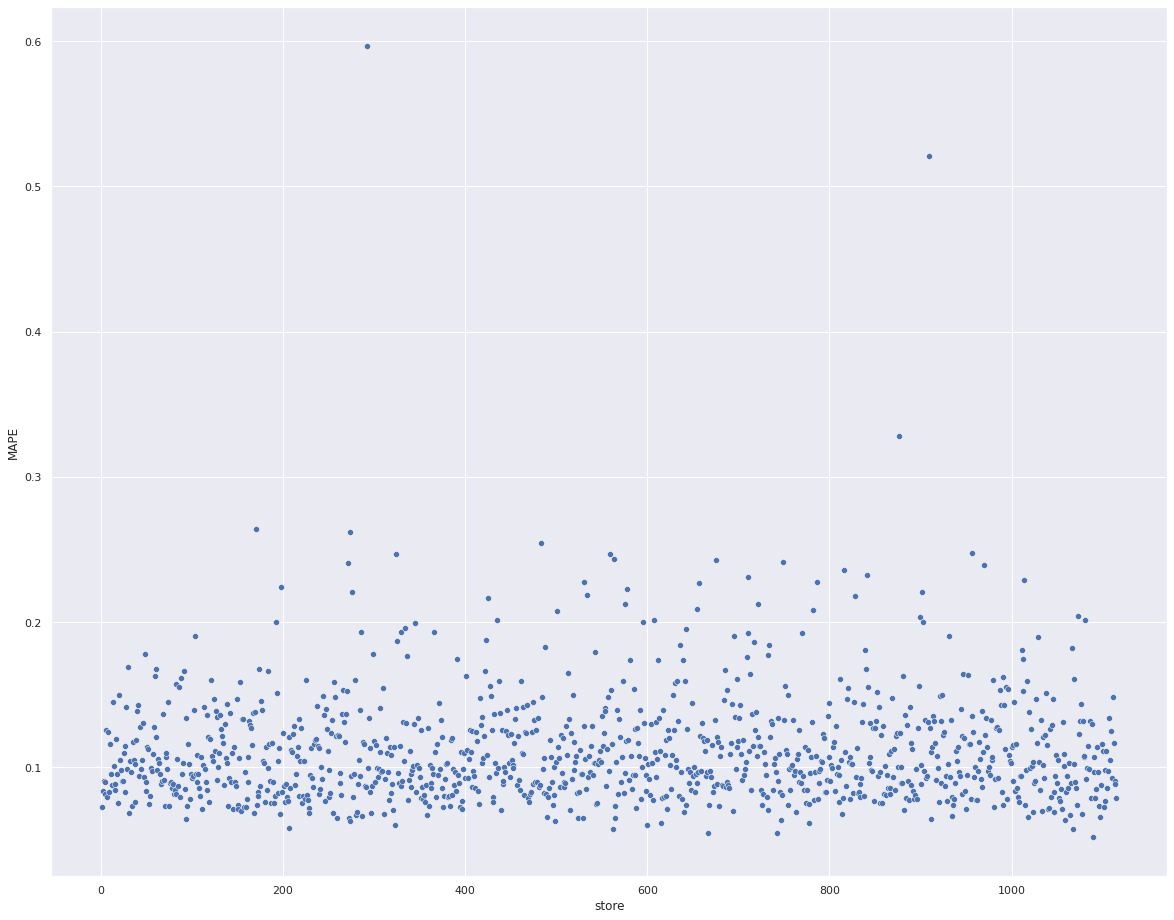

In [105]:
sns.scatterplot( x='store', y='MAPE', data=df92 ) #grafico de ponto pra ver a distribuição dos erros por loja

In [106]:
df92 #predictions um pouco diferentes por causa xgboost

#acuracia é pra metodo de classficação, mexe com erro e acerto(quantidade), regressão é voltado pra valores proximo do esperado. 

#proximo ciclo, entende pq algumas lojas tem o MAPE tao ruim, proxino ciclo, fazer mudanças especficas, tentar entende os motivos. 

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,168295.562500,167980.397190,168610.727810,315.165310,0.072562
1,2,180356.796875,179941.487470,180772.106280,415.309405,0.083774
2,3,268657.031250,268005.078290,269308.984210,651.952960,0.090202
3,4,346734.812500,345882.240353,347587.384647,852.572147,0.081181
4,5,173824.968750,173434.022454,174215.915046,390.946296,0.090001
...,...,...,...,...,...,...
1110,1111,180194.078125,179523.629441,180864.526809,670.448684,0.148483
1111,1112,337355.843750,336405.149586,338306.537914,950.694164,0.116728
1112,1113,251520.062500,250942.166662,252097.958338,577.895838,0.090591
1113,1114,781938.312500,779867.361698,784009.263302,2070.950802,0.088674


## 9.3 - Total Performance

In [107]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} ) #resumo geral das predições comparando com o pior e melhor cenerario 
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format ) #função para deixar as vendas mais apresentaveis 
df93

,Scenario,Values
0,predictions,"R$286,609,984.00"
1,worst_scenario,"R$285,777,418.68"
2,best_scenario,"R$287,442,567.95"


## 9.4 - Machine Learning Performance

In [108]:
df9['error'] = df9['sales'] - df9['predictions'] # error basico, variavel c as reais vendas menos as vendas preditas 
df9['error_rate'] = df9['predictions'] / df9['sales'] #media do erro pela venda real, o numero ideal é 1 

/tmp/ipykernel_6435/457955778.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions'] # error basico, variavel c as reais vendas menos as vendas preditas
/tmp/ipykernel_6435/457955778.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales'] #media do erro pela venda real, o numero ideal é 1


/home/diego/.pyenv/versions/3.10.1/envs/DataScienceEmProducao/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/diego/.pyenv/versions/3.10.1/envs/DataScienceEmProducao/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='predictions', ylabel='error'>

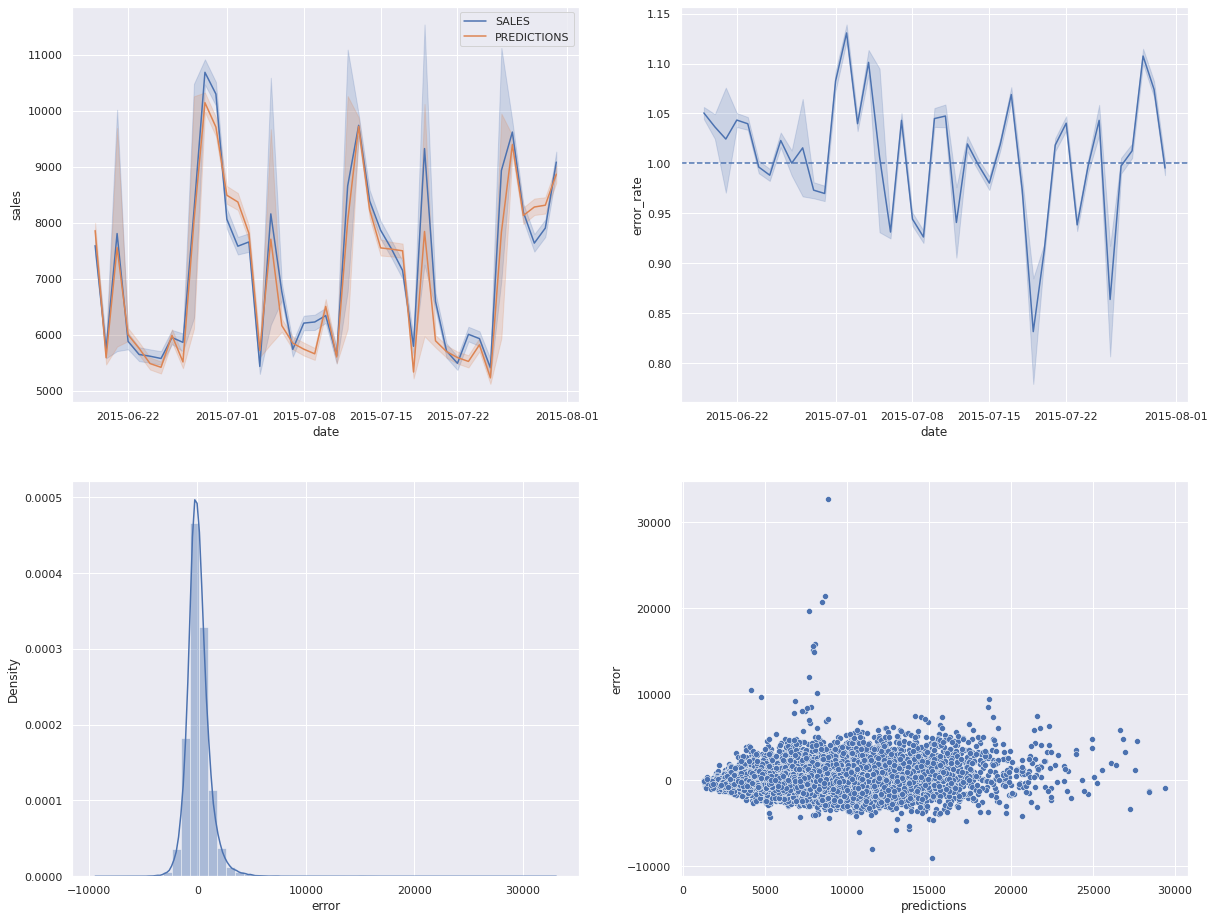

In [109]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' ) # grafico com a distribuição das vendas reais e previstas, o sombreado é as lojas (maximos e minimos), podemos ver nas linhas que as prediçoes acompanharam bem o comportamento 
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 ) # curvas em volta da linha ideal( podemos observar que não varia muito, ela sempre fica perto de 1) #SUPERESTIMADO = acima da linha, SUBESTIMADO = abaixo da linha 
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 ) #distribuição do erro perto da gausiana(normal) isso significa uma boa distribuição!
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 ) # grafico usado em analise de residuo(o do erro tbm) estudar mais dps, demonstra os pontos fracos e como melhorar a acuracia atravez do tratamento desses dados
                       #distribuição concentrada em cone, o erro precisa ficar dentro de um tubo a grande parte, nosso modelo ta legal em termos da analise de residuo
sns.scatterplot( df9['predictions'], df9['error'] ) 

# 10.0 PASSO 10 - DEPLOY  MODEL TO PRODUCTION 

In [7]:
pickle.dump(model_xgb_tuned, open('/home/diego/repos/DataScience-em-Producao/model/model_rosmann.pkl','wb'))

NameError: name 'model_xgb_tuned' is not defined

## 10.1 - Rossmann Class

In [8]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        
        self.home_path = '/home/diego/repos/DataScience-em-Producao/' #variavel que vai trazer o caminho da nossa maquina, pois precisamos passar os caminhos completos e não relativos
        
        self.competiton_distance_scaler    = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl','rb')) #self são variaveis dentro da classe rossmann que não pode ser acessadas de fora
                                                                                                                                     #precisamos ter um metodo instanciado aqui dentro para ter acesso as variaveis

        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))

        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))

        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))

        self.store_type_scaler             = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
                                         
    def data_cleaning(self, df1):
        
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday','StoreType', 'Assortment','CompetitionDistance','CompetitionOpenSinceMonth',                                                                 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x) 

        cols_new = list(map(snakecase, cols_old))

        #rename 
        df1.columns = cols_new  
        
        ## 1.3. Data Types
        df1['date'] = pd.to_datetime(df1['date'])
        
        #competition_distance 
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

        #competition_open_since_month 
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)


        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)


        #promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        #promo2_since_year 
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        #promo_interval 
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7:'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace = True) 
        
        df1['month_map'] = df1['date'].dt.month.map(month_map)
    
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis =1)

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
    
    def feature_engineering(self, df2):
        #year
        df2['year'] = df2['date'].dt.year 

        #month
        df2['month'] = df2['date'].dt.month

        #day
        df2['day'] = df2['date'].dt.day

        #week of year
        df2['week_of_week'] = df2['date'].dt.isocalendar().week

        #year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        #competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 ) 
        
        df2['competition_time_month'] = ((df2['date']-df2['competition_since'] )/30).apply( lambda x: x.days).astype(int) 
        
        #promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str) 

        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x +'-1', '%Y-%W-%w')-datetime.timedelta(days=7)) 

        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days ).astype(int) 
        
        #assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended') 
        
        #state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday'if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' ) 
    
        #3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]
        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval','month_map']  
                                                     
        df2 = df2.drop (cols_drop, axis = 1)
        
                                                         
        return df2
    
    def data_preparation(self, df5):
        
        #competition_distance
        df5['competition_distance'] = self.competiton_distance_scaler.transform (df5[['competition_distance']].values) 

        #competition_time_month 
        df5['competition_time_month'] = self.competition_time_month_scaler.transform (df5[['competition_time_month']].values)

        #promo_time_week 
        df5['promo_time_week'] = self.promo_time_week_scaler.transform (df5[['promo_time_week']].values) 

        # year 
        df5['year'] = self.year_scaler.transform (df5[['year']].values)
    
        ## 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'],columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.transform(df5['store_type'] )
        
        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )
       
        ### 5.3.3. Nature Transformation
        
        #day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30))) 

        #week_of_year
        df5['week_of_week_sin'] = df5['week_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/52))) 
        df5['week_of_week_cos'] = df5['week_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/52))) 
        
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )
        
        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )
        
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment','competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year',
                          'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos','day_sin', 'day_cos', 'week_of_week_sin', 'week_of_week_cos']
        
        
        return df5[cols_selected]
                                                         
    def get_prediction(self, model, original_data, test_data): #self: parametro para ter acesso as variaveis usadas na classe Rossmann
                                                               #model: modelo de predição a aplicar as predições no dataset recebido
                                                               #original data: dataset original com os dados onde vai ser anexada a coluna de predições e sera retornada ao solicitante (dicionário)
                                                               #test_data = solicitação rebecida para realizarmos as predições 
        #prediction
        pred = model.predict(test_data)
        
        #join pred into the original data  
        original_data['prediction'] = expm1(pred) #dataframe que recebemos como solicitação mais a coluna de previsões realizada pelo metodo 
                                                         
        return original_data.to_json(orient='records', date_format='iso') #como a comunicação entre sistemas é o json, precisamos retornar nossos dados para este formato
                                                                          #date_format = parametro para não ter a data bagunçada

## 10.2 - API Handler

In [9]:
from flask import Flask, request, Response #classe onde as funções dessa biblioteca trabalham bem com o API
import pandas as pd
from rossmann.Rossmann import Rossmann #rossmann = pacote, pasta aonde está nosso script | Rossmann = nome do arquivo .py | Rossmann = classe dentro do nosso arquivo 
import pickle

#primeira coisa que o API vai fazer quando começar, vai ser guardar nosso modelo de predição em memoria. Vai ficar esperando com o endpoint ativo e o modelo em memoria.
#Recebeu uma requisição, ela prepara os dados, passa pro modelo, o modelo faz a predição, devolve a predição, anexamos nos dados originais e devolvemos pra quem solicitou. 

#load model
model = pickle.load(open('/home/diego/repos/DataScience-em-Producao/model/model_rosmann.pkl','rb')) #guardando nosso modelo em memória

#initialize API
app = Flask(__name__) #instanciando a classe 

@app.route('/rossmann/predict' , methods = ['POST']) #ativando o endpoint
                                                     #metodo POST = só recebe metodos que ele envia algum dado para receber | /rossmann/predict = endpoint (rota, url que recebera dados, requests)

def rossmann_predict(): #toda vez que o nosso endpoint recebe uma chamada via POST, ele executa a primeira função embaixo dele
    test_json = request.get_json() #função que vai pegar os dados (enviado via API) que recebemos e vamos fazer as mudanças nele
                                   #get.json é um metodo de uma classe chamada request
                                   #test_json = variavel que vai receber as requisões em formato json
        
    if test_json: #there is data  | precisamos fazer um teste para saber se estamos recebendo os dados via POST(API), caso seja falso precisamos retorna uma resposta pro codigo que não foi enviado dados
                  #leremos os dados de duas formas, dict= quando vier uma linha de requisição, e quando recebermos mais de uma linha de requisição 
        if isinstance(test_json, dict): #Unique example  | isinstance = função que retorna True, se a classe no paramatetro for a classe espeficada.
            test_raw = pd.DataFrame(test_json, index=[0]) #Uma linha de requisição, pegaremos esse json e transformaremos em um dataframe. 
        else: #multiple example. Neste caso, também jogaremos o json para um dataframe, porém, com mais de uma linha
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        
        #agora que definimos as formas de recolher as informações dessas API, e ler em dataframe, precisamos instanciar os caminhos das classes criadas por nos
            
        #Instantiate Rossmann Class
        pipeline = Rossmann() 
        
        #data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        #feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        #data preparation
        df3 = pipeline.data_preparation(df2)
        
        #preidction 
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response 
        
            
    else:
        return Response ('{}', status=200, mimetype ='application/json' ) #Response= classe responsavél por retornar a resposta pra quem fez a requisão via API
                                                                          #status = significa que a resquisão deu certo mas a execução deu errado(por isso retornaremos vazio) | mimetype = mesmo headler que usamos pra                                                                              fazer a request

if __name__ == '__main__': #função main é aonde o handler.py (script python) busca primeiro dentro do nosso script
    app.run ('0.0.0.0')    #quando encontramos a função main, iniciamos o nosso local host, que essa aplicação do flask ta rodando na minha máquina(local)

ModuleNotFoundError: No module named 'rossmann'

## 10.3 - API Tester

In [4]:
#loading test dataset
df10 = pd.read_csv('data/test.csv')

In [5]:
#merge test dataset + store
df_test= pd.merge(df10, df_store_raw, how='left', on='Store')

#choose store for prediction
df_test = df_test[df_test['Store'].isin([16, 12, 22,110])] #isin function: permite fazer seleções de séries, dicionários. 

#remove closed days
df_test = df_test[df_test['Open'] != 0] #lojas sempre abertas
df_test = df_test[-df_test['Open'].isnull()] #linhas sem o open vazio
df_test = df_test.drop('Id', axis=1)

In [6]:
#Convert datafram to json
data = json.dumps(df_test.to_dict(orient='records')) #precisamos passar o dataframe pra json, pois ele é a comunicação comum entre sistemas, quando se deseja compartilhar arquivos entre sistemas, usamos o json!
                                                    #precisamos antes converter o dataframe em dicionário, passamos o metodo records, pra saber como passaremos pra dicionário
                                                    #depois, passamos pra formato json, atraves da função dumps do proprio json

In [7]:
# API call precisamos de 3 coisas para criar a API pra mandar pro nosso modelo 
#url = 'http://0.0.0.0:5000/rossmann/predict' #endpoint para onde enviaremos nossos dados, http = protocolo da internet(endereço das maquinas dos servidores). 5000 = porta padrão do flask, precisamos sempre indicar que 
url = 'https://rossmann-model-diego.herokuapp.com/rossmann/predict'                                           #porta queremos entrar
                                            #tradução: queremos entrar nesse endereçi 0.0.0.0 que é o endereço de máquina local, nesta porta 5000,quando entrar nessa porta, meu endpoint será o /rossmann/predict
data = data #os dados a serem enviados 
header = {'Content-type': 'application/json'}#indica pra API que tipo de requisião ela ta fazendo

r = requests.post(url, data, headers=header)
print('Status Code {}'.format(r.status_code)) #toda API, devolve um status code, para dizer se aquela requisição é válida ou não. EX= code 404 error
#post envia um pedido com obrigatoriedade de dados
#get envia um pedido sem dados

Status Code 200


In [8]:
d1 = pd.DataFrame(r.json(), columns =r.json()[0].keys())

In [16]:
d1

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_week,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,12,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,extended,1070.0,9,2015,1,13,2010,"Jan,Apr,Jul,Oct",Sept,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2010-03-22T00:00:00.000Z,286,6639.834961
1,16,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,extended,3270.0,9,2015,0,38,2015,0,Sept,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2015-09-14T00:00:00.000Z,0,4580.557617
2,22,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sept,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,4340.282227
3,110,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,extended,46590.0,4,2013,0,38,2015,0,Sept,0,2015,9,17,38,2015-37,2013-04-01T00:00:00.000Z,29,2015-09-14T00:00:00.000Z,0,4841.062012
4,12,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,a,extended,1070.0,9,2015,1,13,2010,"Jan,Apr,Jul,Oct",Sept,0,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2010-03-22T00:00:00.000Z,286,6612.884766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,110,1,2015-08-03T00:00:00.000Z,1.0,1,regular_day,1,a,extended,46590.0,4,2013,0,32,2015,0,Aug,0,2015,8,3,32,2015-31,2013-04-01T00:00:00.000Z,28,2015-08-03T00:00:00.000Z,0,3169.638916
159,12,6,2015-08-01T00:00:00.000Z,1.0,0,regular_day,0,a,extended,1070.0,8,2015,1,13,2010,"Jan,Apr,Jul,Oct",Aug,0,2015,8,1,31,2015-30,2015-08-01T00:00:00.000Z,0,2010-03-22T00:00:00.000Z,279,5101.505859
160,16,6,2015-08-01T00:00:00.000Z,1.0,0,regular_day,0,a,extended,3270.0,8,2015,0,31,2015,0,Aug,0,2015,8,1,31,2015-30,2015-08-01T00:00:00.000Z,0,2015-07-27T00:00:00.000Z,0,3680.304199
161,22,6,2015-08-01T00:00:00.000Z,1.0,0,regular_day,0,a,basic,1040.0,8,2015,1,22,2012,"Jan,Apr,Jul,Oct",Aug,0,2015,8,1,31,2015-30,2015-08-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,166,3370.174072


In [9]:
d2 = d1[['store','prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
            d2.loc[i, 'store'],
            d2.loc[i ,'prediction']))

Store Number 12 will sell R$236,021.85 in the next 6 weeks
Store Number 16 will sell R$154,877.89 in the next 6 weeks
Store Number 22 will sell R$146,799.02 in the next 6 weeks
Store Number 110 will sell R$155,870.01 in the next 6 weeks
